In [ ]:
# importing the relevant libraries
# only install the packages if they are not already available

# !pip install -U dataprep
# !pip install category_encoders
# !pip install optuna
# !pip install pygam

# importing relevant packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.graph_objects as go
import sklearn
import torch
import xgboost as xgb
import lightgbm as lgb
import optuna
import pygam

from category_encoders.cat_boost import CatBoostEncoder
from dataprep.eda import plot_correlation
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from plotly.offline import init_notebook_mode
from scipy.stats import norm, skew, boxcox_normmax
from scipy.special import boxcox1p
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_log_error,mean_squared_error,r2_score,mean_absolute_error,f1_score
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected = True)

# this notebook was tested on Google Colab

print("Numpy Version: {}".format(np.__version__)) # numpy tested on version 1.21.6
print("Seaborn Version: {}".format(sns.__version__)) # seaborn tested on verison 0.11.2
print("Pandas Version: {}".format(pd.__version__)) # pandas tested on version 1.3.5
print("Sklearn Version: {}".format(sklearn.__version__)) # sklearn tested on version 1.0.2
print("Torch Version: {}".format(torch.__version__)) # torch tested on version 1.11.0+cu113 (cuda)
print("XGBoost Version: {}".format(xgb.__version__)) # xgboost tested on version 0.9
print("LightGBM Version: {}".format(lgb.__version__)) # lightgbm tested on 2.2.3
print("Optuna Version: {}".format(optuna.__version__)) # optuna tested on version 2.10.0
print("Pygam Version: {}".format(pygam.__version__)) # pygam tested on version 0.8.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Numpy Version: 1.21.6
Seaborn Version: 0.11.2
Pandas Version: 1.3.5
Sklearn Version: 1.0.2
Torch Version: 1.11.0+cu113
XGBoost Version: 0.90
LightGBM Version: 2.2.3
Optuna Version: 2.10.0
Pygam Version: 0.8.0


In [ ]:
# cell to be deleted for submission

# from google.colab import files
# uploaded = files.upload()

In [ ]:
# importing the dataset and printing the first 5 rows
df = pd.read_csv("listings.csv")
df.head(5)

id                         listing_url       scrape_id last_scraped  \
0  11156  https://www.airbnb.com/rooms/11156  20211207182240   2021-12-08   
1  14250  https://www.airbnb.com/rooms/14250  20211207182240   2021-12-08   
2  15253  https://www.airbnb.com/rooms/15253  20211207182240   2021-12-08   
3  44545  https://www.airbnb.com/rooms/44545  20211207182240   2021-12-08   
4  58506  https://www.airbnb.com/rooms/58506  20211207182240   2021-12-08   

                                                name  \
0                               An Oasis in the City   
1                                Manly Harbour House   
2  Unique Designer Rooftop Apartment in City Loca...   
3             Sunny Darlinghurst Warehouse Apartment   
4                      Studio Yindi @ Mosman, Sydney   

                                         description  \
0  Very central to the city which can be reached ...   
1  Beautifully renovated, spacious and quiet, our...   
2  Penthouse living at it best ... You will be st...   
3  Sunny warehouse/loft apartment in the heart of...   
4  An open plan apartment, which opens onto a spa...   

                               neighborhood_overview  \
0  It is very close to everything and everywhere,...   
1  Balgowlah Heights is one of the most prestigio...   
2  The location is really central and there is nu...   
3  Darlinghurst is home to some of Sydney's best ...   
4  Mosman is a smart, middle to upper class subur...   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/2797669/17895...    40855   
1  https://a0.muscache.com/pictures/56935671/fdb8...    55948   
2  https://a0.muscache.com/pictures/46dcb8a1-5d5b...    59850   
3  https://a0.muscache.com/pictures/a88d8e14-4f63...   112237   
4  https://a0.muscache.com/pictures/23497720/d30f...   279955   

                                   host_url  ... review_scores_communication  \
0   https://www.airbnb.com/users/show/40855  ...                        4.77   
1   https://www.airbnb.com/users/show/55948  ...                        4.33   
2   https://www.airbnb.com/users/show/59850  ...                        4.67   
3  https://www.airbnb.com/users/show/112237  ...                        4.96   
4  https://www.airbnb.com/users/show/279955  ...                        4.90   

  review_scores_location review_scores_value           license  \
0                   4.82                4.71               NaN   
1                   4.67                4.33            Exempt   
2                   4.70                4.47  PID-STRA-24061-7   
3                   4.93                4.77               NaN   
4                   4.73                4.68     PID-STRA-6093   

  instant_bookable calculated_host_listings_count  \
0                f                              1   
1                f                              2   
2                t                              1   
3                f                              1   
4                f                              1   

  calculated_host_listings_count_entire_homes  \
0                                           0   
1                                           2   
2                                           0   
3                                           1   
4                                           1   

  calculated_host_listings_count_private_rooms  \
0                                            1   
1                                            0   
2                                            1   
3                                            0   
4                                            0   

  calculated_host_listings_count_shared_rooms reviews_per_month  
0                                           0              1.34  
1                                           0              0.04  
2                                           0              3.21  
3                                           0              0.56  
4                 

## Data Pre-Processing & Cleaning ##

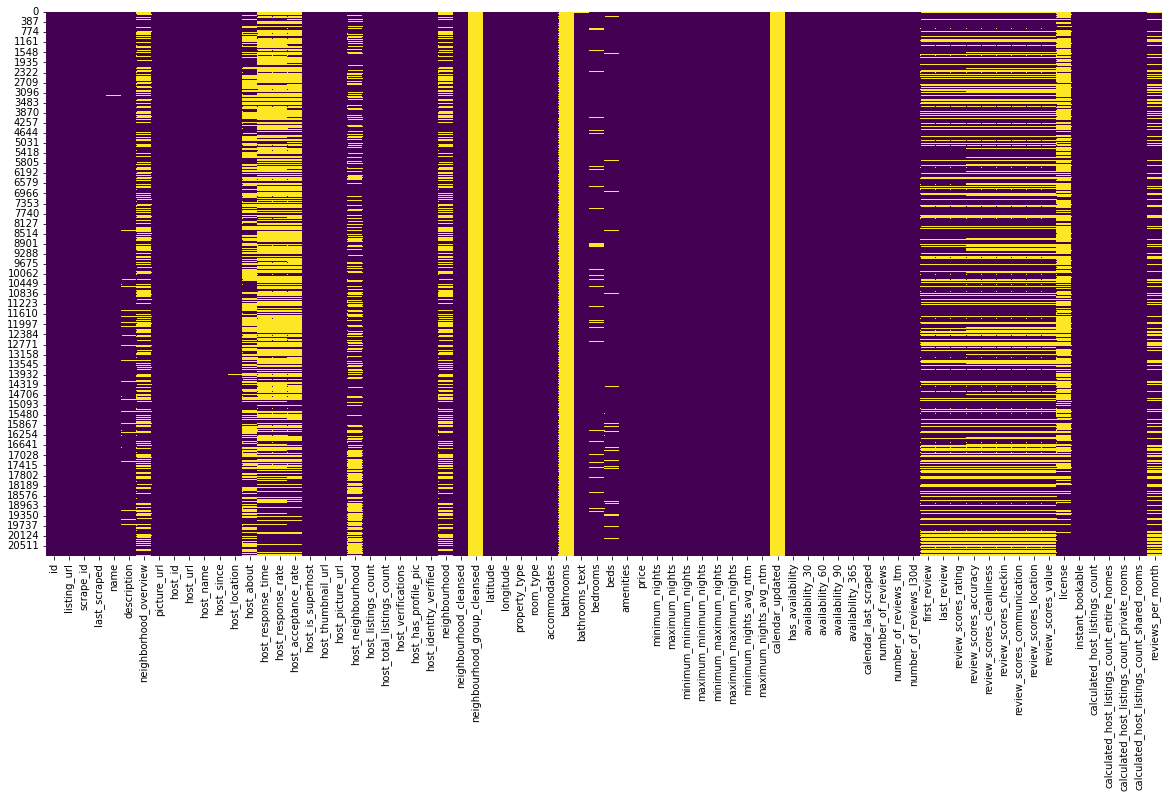

In [ ]:
# visualizing the missing values

fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df.isnull(),cbar=False,cmap='viridis', ax=ax)

#plt.savefig("missing_values_hm.png")

In [ ]:
# dtypes conversion

# last_scraped from object to datetime
# host_since from object to datetime
# first_review from object to datetime
# last_review from object to datetime
# calendar_last_scraped from object to datetime

columns = ['last_scraped', 'host_since', 'first_review', 'last_review', 'calendar_last_scraped']
for col in columns:
    ini_obj = df[col].dtype
    df[col] = pd.to_datetime(df[col], format='%Y/%m/%d')
    conv_obj = df[col].dtype
    print("Column {} has been converted from dtype {} to dtype {}".format(col, ini_obj, conv_obj))

print("\n")

# host_response_time from object to categorical
# room_type from object to categorical
# host_is_superhost from object to categorical (boolean) #boolean values treated as categorical, hereafter all will be addressed as categorical
# host_has_profile_pic from object to categorical (boolean)
# host_identity_verified from object to categorical (boolean)
# has_availability from object to categorical (boolean)
# instant_bookable from object to categorical (boolean)

cat_cols = ['host_response_time', 'room_type', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable']
for col in cat_cols:
    ini_obj = df[col].dtype
    df[col] = df[col].astype("category")
    conv_obj = df[col].dtype
    print("Column {} has been converted from dtype {} to dtype {}".format(col, ini_obj, conv_obj))

print("\n")

# host_response_rate from object to float64
# host_acceptance_rate from object to float64

def p2f(x):
    return float(x.strip('%'))/100

flt_cols = ['host_response_rate', 'host_acceptance_rate']
for col in flt_cols:
    ini_obj = df[col].dtype
    df[col] = df[col].map(p2f, na_action='ignore')
    conv_obj = df[col].dtype
    print("Column {} has been converted from dtype {} to dtype {}".format(col, ini_obj, conv_obj))

print("\n")

# converting all ids from integer to string
# id from int64 to object
# scrape_id from int64 to object
# host_id from int64 to object

string_columns = ['id', 'scrape_id', 'host_id']
for col in string_columns:
    ini_obj = df[col].dtype
    df[col] = df[col].astype('object')
    conv_obj = df[col].dtype
    print("Column {} has been converted from dtype {} to dtype {}".format(col, ini_obj, conv_obj))

print("\n")

def price2f(x):
    x_stripp = x.strip('$')
    x_stripc = x_stripp.replace(',','')
    return float(x_stripc)

price_column = ['price']
for col in price_column:
    ini_obj = df[col].dtype
    df[col] = df[col].map(price2f, na_action='ignore')
    conv_obj = df[col].dtype
    print("Column {} has been converted from dtype {} to dtype {}".format(col, ini_obj, conv_obj))

Column last_scraped has been converted from dtype object to dtype datetime64[ns]
Column host_since has been converted from dtype object to dtype datetime64[ns]
Column first_review has been converted from dtype object to dtype datetime64[ns]
Column last_review has been converted from dtype object to dtype datetime64[ns]
Column calendar_last_scraped has been converted from dtype object to dtype datetime64[ns]


Column host_response_time has been converted from dtype object to dtype category
Column room_type has been converted from dtype object to dtype category
Column host_is_superhost has been converted from dtype object to dtype category
Column host_has_profile_pic has been converted from dtype object to dtype category
Column host_identity_verified has been converted from dtype object to dtype category
Column has_availability has been converted from dtype object to dtype category
Column instant_bookable has been converted from dtype object to dtype category


Column host_response_rate 

In [ ]:
# dropping columns with all NaN values
# these columns add no value to the dataset, even with imputation they will all be the same number
df = df.drop(["bathrooms", "calendar_updated", 'neighbourhood_group_cleansed'], axis=1)

# creating a separate dataset without geographical coordinates for EDA purposes
df_nogeo = df.drop(["latitude", "longitude"], axis=1)

# creating a separate dataset without response variable (price) for EDA purposes
df_price = df["price"]
df_features = df_nogeo.drop(["price"],axis=1)

# df = pre-processed original dataset (excluded irrelevant columns)
# df_nogeo = pre-process original dataset, less the latitude and longitude
# df_price = only the response variable column
# df_features = pre-processed original dataset, less response (price), longitude and latitude

## Exploratory Data Analysis ##

In [ ]:
# separating numerical and categorical features for eda purposes

df_num = df_nogeo.select_dtypes(include = ['float64', 'int64'])  # numeric variables
df_cat = df_nogeo.select_dtypes(include = ['category']) # categorical variables

### Univariate Analysis

In [ ]:
# descriptive statistics for numerical variables

df_num.describe().T

count          mean  \
host_response_rate                             7884.0  9.046258e-01   
host_acceptance_rate                           8846.0  7.755584e-01   
host_listings_count                           20877.0  1.094937e+01   
host_total_listings_count                     20877.0  1.094937e+01   
accommodates                                  20880.0  3.383333e+00   
bedrooms                                      19444.0  1.704330e+00   
beds                                          19976.0  2.039848e+00   
price                                         20880.0  2.511662e+02   
minimum_nights                                20880.0  6.218946e+01   
maximum_nights                                20880.0  9.050510e+02   
minimum_minimum_nights                        20879.0  6.156305e+01   
maximum_minimum_nights                        20879.0  6.256669e+01   
minimum_maximum_nights                        20879.0  1.038155e+05   
maximum_maximum_nights                        20879.0  1.646630e+06   
minimum_nights_avg_ntm                        20879.0  6.207167e+01   
maximum_nights_avg_ntm                        20879.0  1.501655e+06   
availability_30                               20880.0  7.062787e+00   
availability_60                               20880.0  1.697352e+01   
availability_90                               20880.0  2.810316e+01   
availability_365                              20880.0  1.020672e+02   
number_of_reviews                             20880.0  1.789574e+01   
number_of_reviews_ltm                         20880.0  2.880364e+00   
number_of_reviews_l30d                        20880.0  2.987548e-01   
review_scores_rating                          15071.0  4.471015e+00   
review_scores_accuracy                        14459.0  4.730401e+00   
review_scores_cleanliness                     14469.0  4.588982e+00   
review_scores_checkin                         14452.0  4.824107e+00   
review_scores_communication                   14469.0  4.821152e+00   
review_scores_location                        14453.0  4.816509e+00   
review_scores_value                           14448.0  4.629979e+00   
calculated_host_listings_count                20880.0  8.094540e+00   
calculated_host_listings_count_entire_homes   20880.0  6.718966e+00   
calculated_host_listings_count_private_rooms  20880.0  1.274713e+00   
calculated_host_listings_count_shared_rooms   20880.0  6.020115e-02   
reviews_per_month                             15071.0  6.415009e-01   

                                                       std    min      25%  \
host_response_rate                            2.424745e-01   0.00     0.97   
host_acceptance_rate                          3.159217e-01   0.00     0.68   
host_listings_count                           4.099329e+01   0.00     1.00   
host_total_listings_count                     4.099329e+01   0.00     1.00   
accommodates                                  2.188119e+00   1.00     2.00   
bedrooms                                      1.036077e+00   1.00     1.00   
beds                                          1.538269e+00   1.00     1.00   
price                                         4.985989e+02  13.00    80.00   
minimum_nights                                5.273935e+01   1.00     4.00   
maximum_nights                                4.070761e+02   1.00  1125.00   
minimum_minimum_nights                        5.292667e+01   1.00     3.00   
maximum_minimum_nights                        5.226302e+01   1.00     5.00   
minimum_maximum_nights                        1.486192e+07   1.00  1125.00   
maximum_maximum_nights                        5.942631e+07   1.00  1125.00   
minimum_nights_avg_ntm                        5.259581e+01   1.00     4.50   
maximum_nights_avg_ntm                        5.430167e+07   1.00  1125.00   
availability_30                               1.074229e+01   0.00     0.00   
availability_60                               2.271441e+01   0.00     0.00   
availabil

In [ ]:
# descriptive statistics for boolean and categorical variables
df_cat.describe().T

count unique              top   freq
host_response_time       7884      4   within an hour   4585
host_is_superhost       20877      2                f  17841
host_has_profile_pic    20877      2                t  20778
host_identity_verified  20877      2                t  16295
room_type               20880      4  Entire home/apt  13398
has_availability        20880      2                t  20597
instant_bookable        20880      2                f  13516

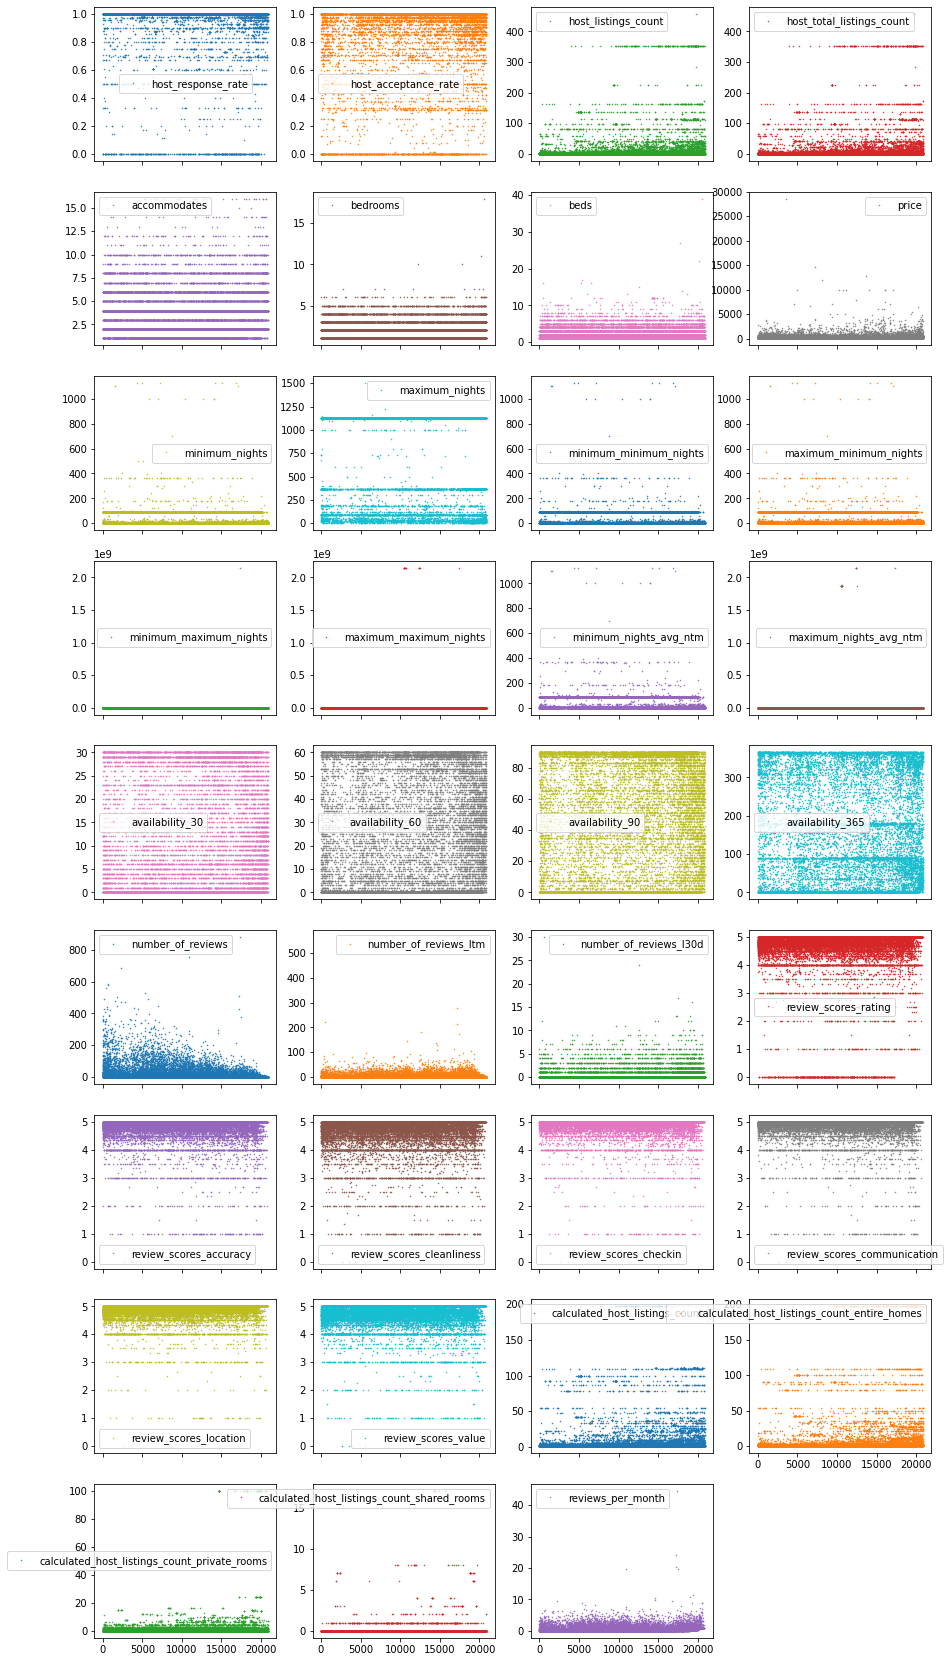

In [ ]:
# scatterplot of all numerical variables

df_num.plot(lw=0, marker=".", subplots=True, layout=(-1, 4),
          figsize=(15, 30), markersize=1);

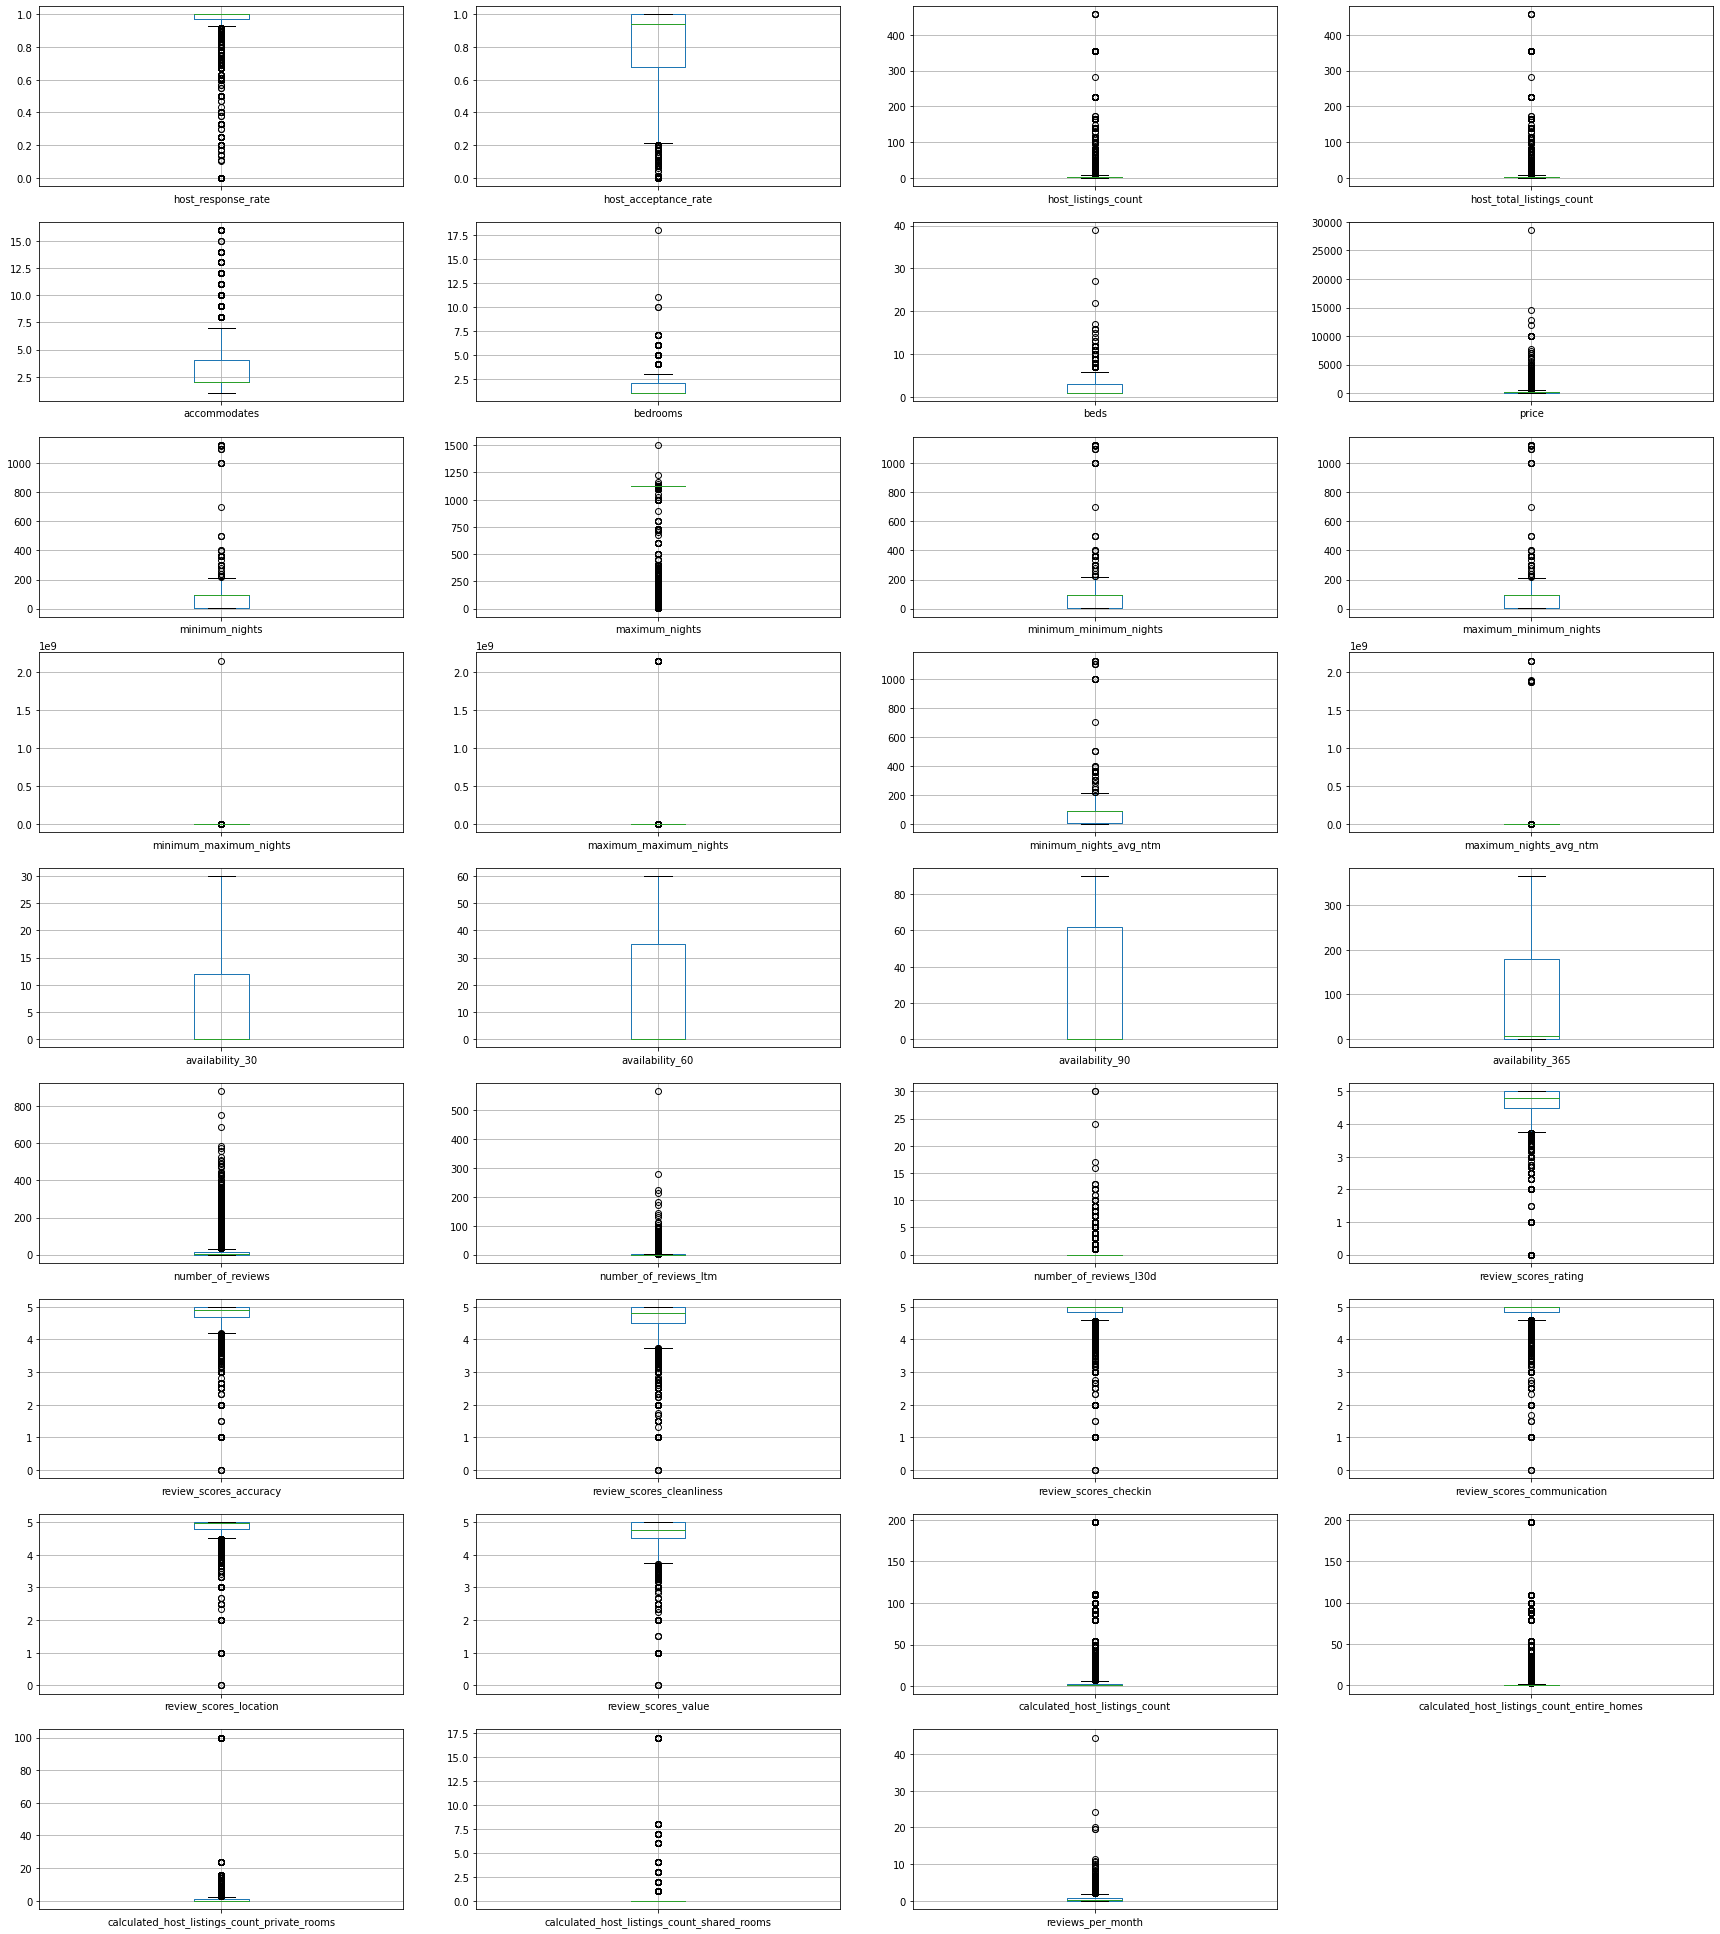

In [ ]:
# plotting the boxplot of all numerical features

fig, ax = plt.subplots(9, 4, figsize=(30,35))
ix = np.ndindex(9, 4)

for col in df_num.columns:
    col_index = df_num.columns.get_loc(col)
    index = next(ix)
    df_num.boxplot([col], ax=ax[index])
    #ax[index].set_xlabel(col)

# remove the 1 unused ax from the plot

for ax in ax.flat[35:]:
    ax.remove()

#plt.savefig("int_against_target_box.png")

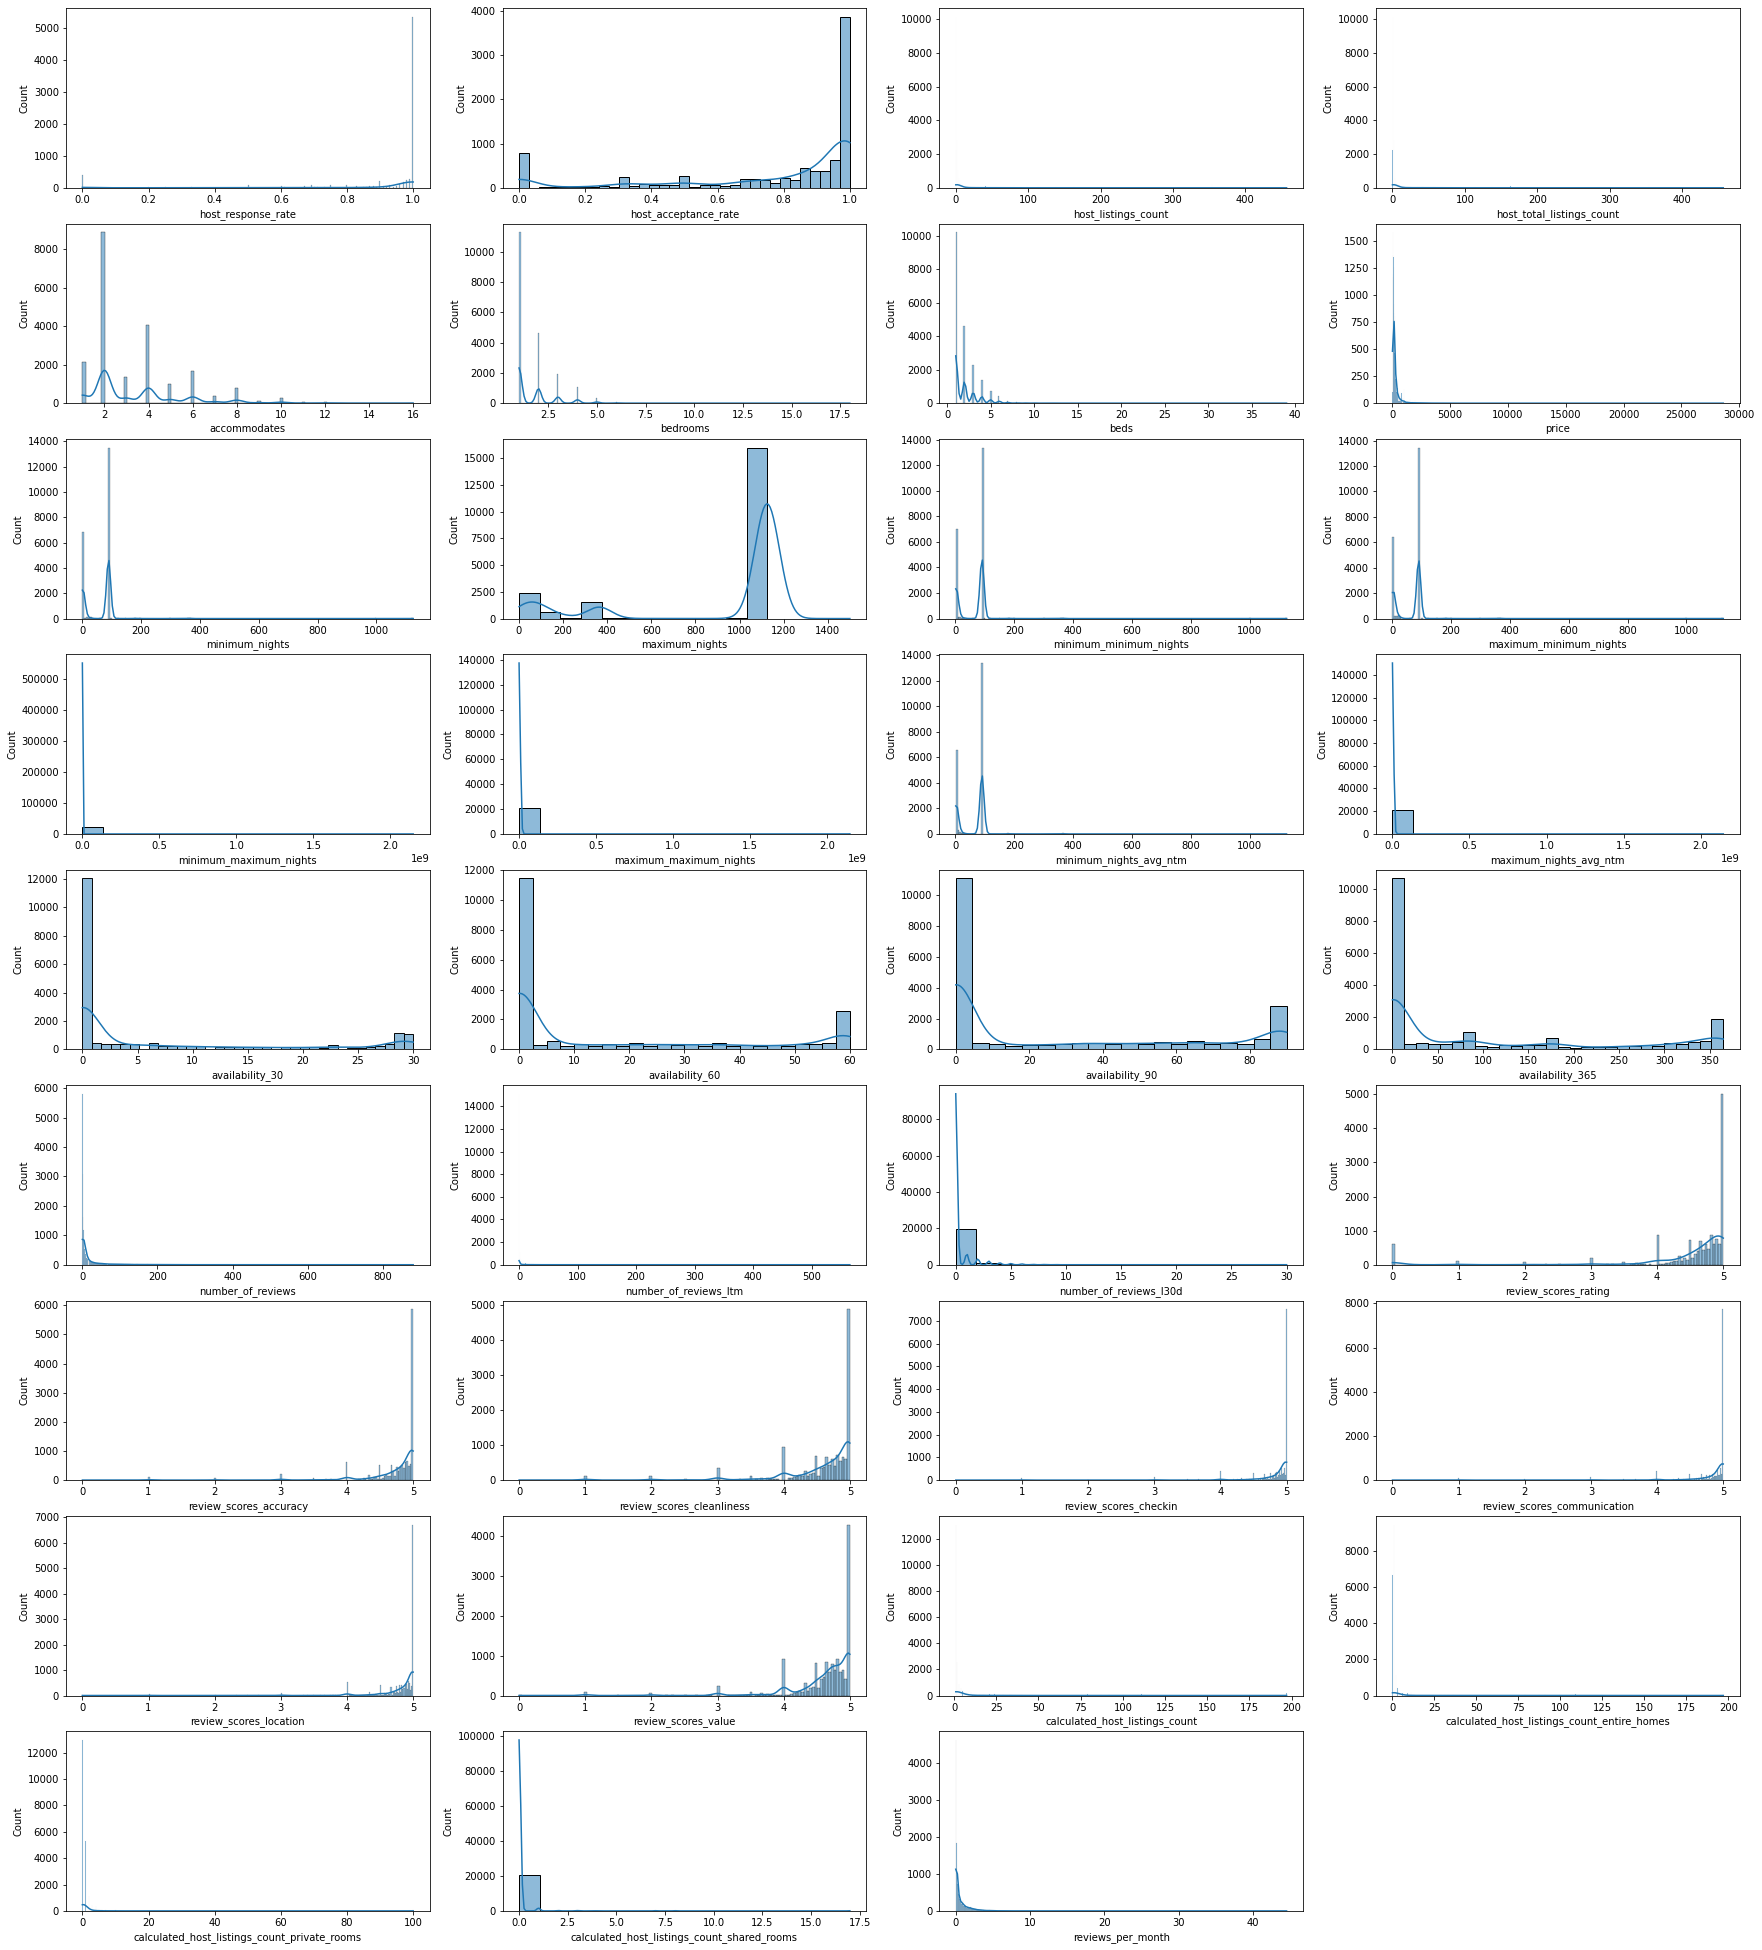

In [ ]:
fig, ax = plt.subplots(9, 4, figsize=(30,35))
ix = np.ndindex(9, 4)

for col in df_num.columns:
    index = next(ix)
    sns.histplot(x = df_num[col], ax=ax[index], kde=True)
    #ax[index].set_xlabel(col)

# remove the 1 unused ax from the plot

for ax in ax.flat[35:]:
    ax.remove()

#plt.savefig("int_against_target_box.png")

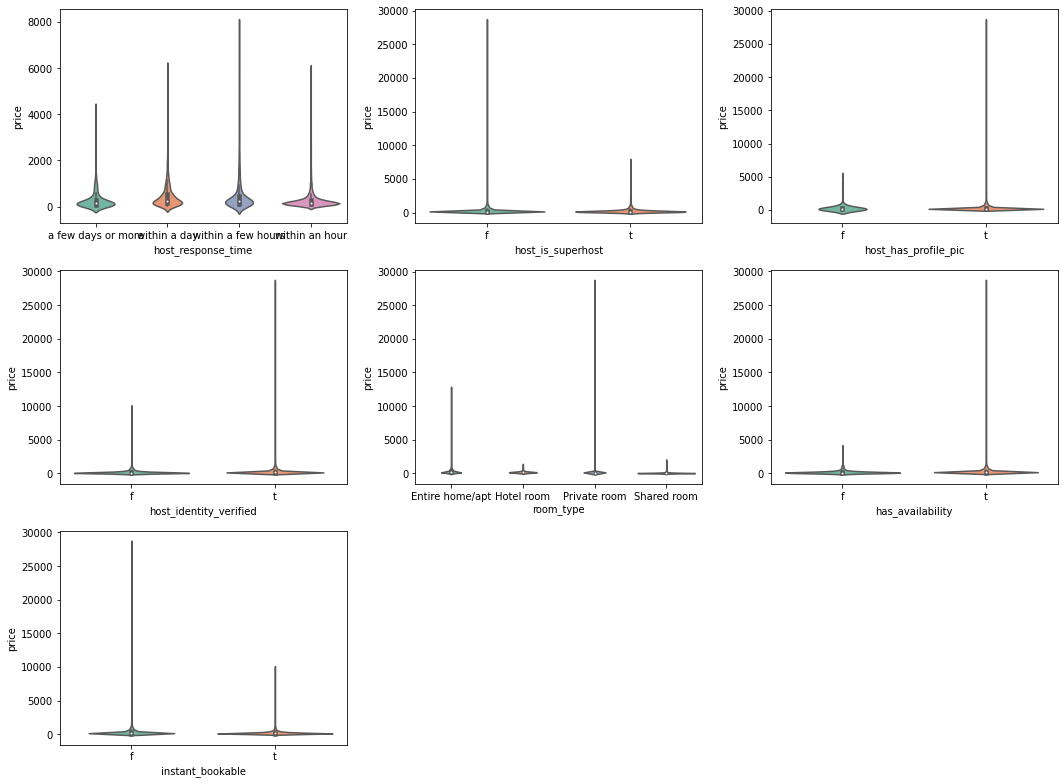

In [ ]:
# violin plot of categorical variables
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(15, 11))

# Loop through these features and plot entries from each feature against `Latitude`
for col, ax in zip(df_cat.columns, axes.ravel()):
    sns.violinplot(data=df_nogeo, x=col, y=df_nogeo["price"], palette="Set2",
                   split=True, ax=ax)
plt.tight_layout();

# remove the 2 unused axes from the plot

for ax in axes.flat[7:]:
    ax.remove()

#plt.savefig("categoricalviolin.png")

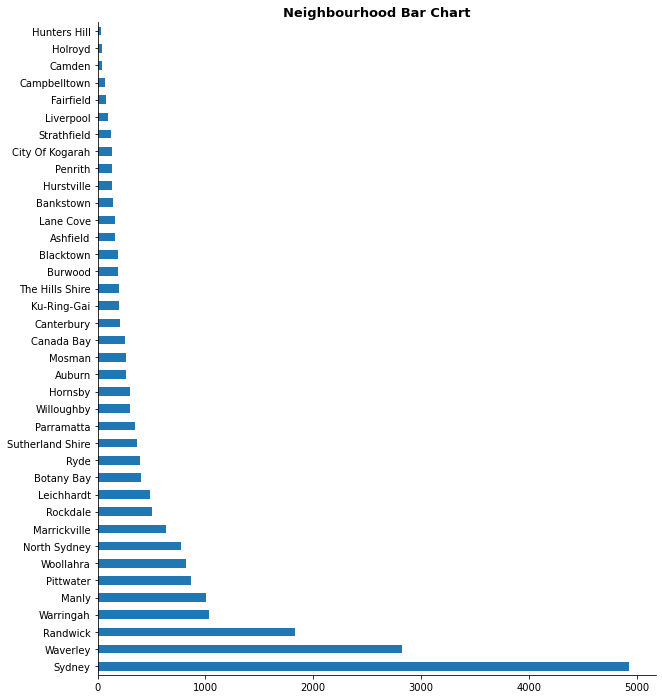

In [ ]:
# count of neighbourhoods bar chart

fig, ax = plt.subplots(figsize=(10,12))
df_nogeo['neighbourhood_cleansed'].value_counts().plot(kind='barh')
sns.despine(fig = fig, ax = ax)
ax.set_title('Neighbourhood Bar Chart', fontweight='bold', fontsize=13)
plt.show()

### Bivariate Analysis and Multivariate Analysis

In [ ]:
# examining the correlation between price (the response variable) with all possible predictor variables

print("Pearson Correlation:")
print(df_nogeo.corr().loc["price",:].sort_values(ascending=False)[:10])
print("\n")
print("Kendall Correlation:")
print(df_nogeo.corr(method = 'kendall').loc["price",:].sort_values(ascending=False)[:10])

# unsurprisingly, some of the highest (linearly) correlated features are accommodates, bedrooms and beds

Pearson Correlation:
price                                          1.000000
bedrooms                                       0.475528
accommodates                                   0.434278
beds                                           0.402607
calculated_host_listings_count_entire_homes    0.105130
calculated_host_listings_count                 0.083661
host_listings_count                            0.079998
host_total_listings_count                      0.079998
availability_365                               0.070030
review_scores_location                         0.051495
Name: price, dtype: float64


Kendall Correlation:
price                                          1.000000
accommodates                                   0.553427
bedrooms                                       0.542375
beds                                           0.475792
calculated_host_listings_count_entire_homes    0.429072
review_scores_location                         0.131245
availability_365                

In [ ]:
# credits to user @arun's answer on stack overflow
# https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5, corr_method = 'pearson'):
    au_corr = df.corr(method = corr_method).abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [ ]:
# inspect the top absolute correlations between all numerical variables

print("Top Absolute Pearson Correlations")
print(get_top_abs_correlations(df_num, 5, 'pearson'))
print("\n")
print("Top Absolute Kendall Correlations")
print(get_top_abs_correlations(df_num, 10, 'kendall'))

Top Absolute Pearson Correlations
host_listings_count     host_total_listings_count    1.000000
maximum_minimum_nights  minimum_nights_avg_ntm       0.998230
maximum_maximum_nights  maximum_nights_avg_ntm       0.997966
minimum_minimum_nights  minimum_nights_avg_ntm       0.996102
minimum_nights          minimum_nights_avg_ntm       0.993870
dtype: float64


Top Absolute Kendall Correlations
host_listings_count     host_total_listings_count    1.000000
minimum_maximum_nights  maximum_nights_avg_ntm       0.986717
maximum_maximum_nights  maximum_nights_avg_ntm       0.978825
minimum_maximum_nights  maximum_maximum_nights       0.965447
minimum_nights          minimum_minimum_nights       0.960870
minimum_minimum_nights  minimum_nights_avg_ntm       0.958634
maximum_minimum_nights  minimum_nights_avg_ntm       0.953729
minimum_nights          minimum_nights_avg_ntm       0.953570
availability_60         availability_90              0.952174
minimum_nights          maximum_minimum_nights 

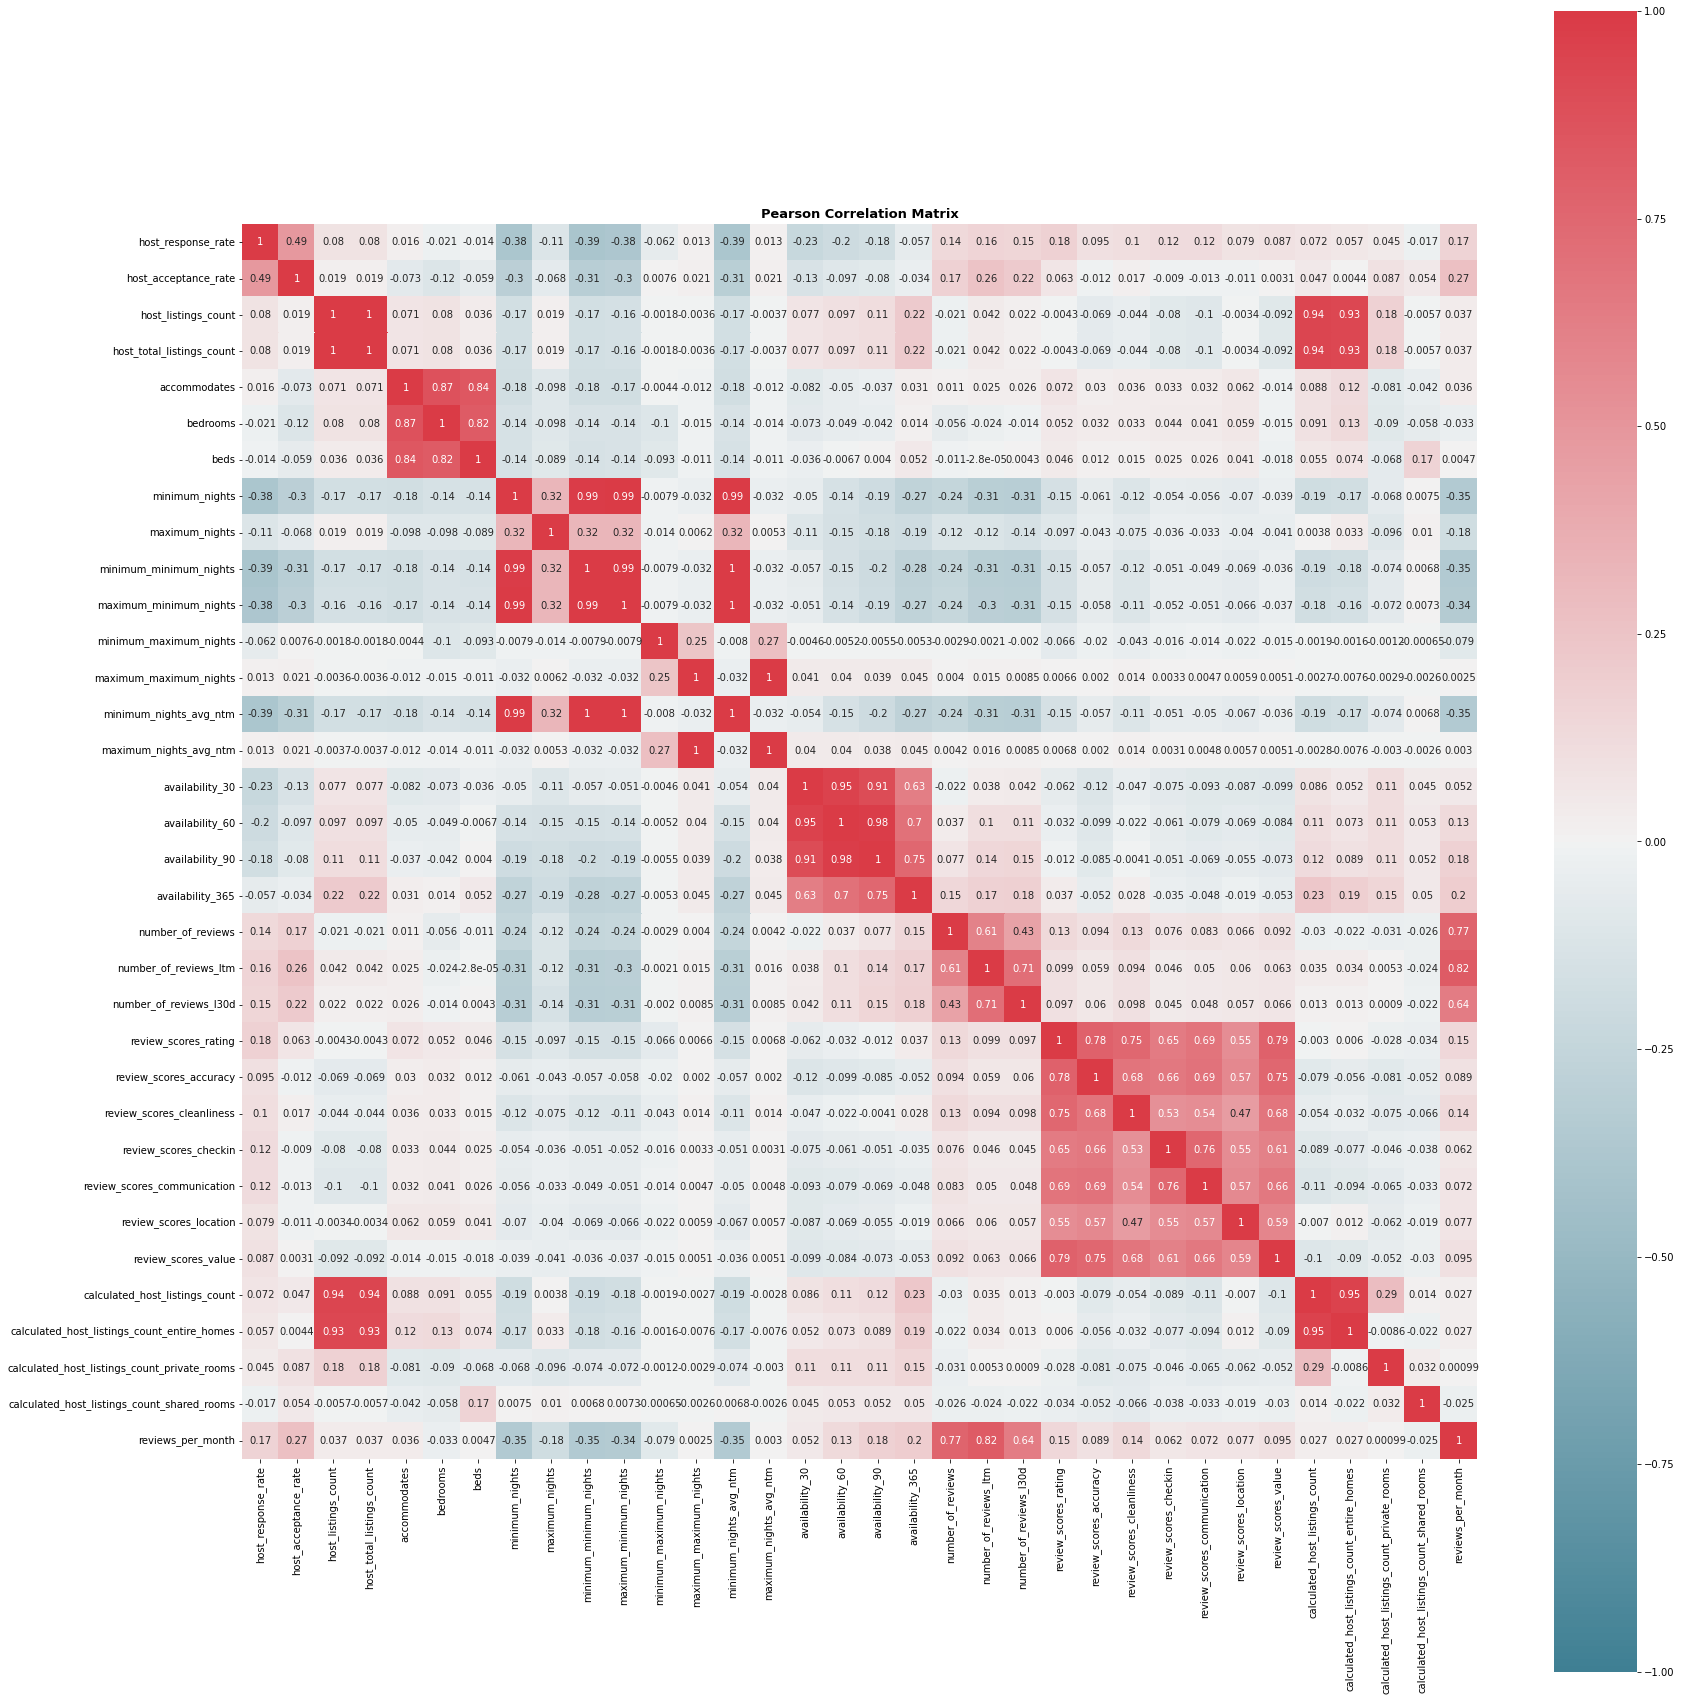

In [ ]:
# Pearson Correlation heatmap between integer features

fig, ax = plt.subplots(figsize=(25,25))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_features.corr(), vmax=1, vmin=-1, center=0, square=True, annot = True, ax=ax, cmap=cmap)
ax.set_title('Pearson Correlation Matrix', fontweight='bold', fontsize=13)
plt.tight_layout()
#plt.show()
#plt.savefig("Pearson Correlation Matrix Heatmap.png")

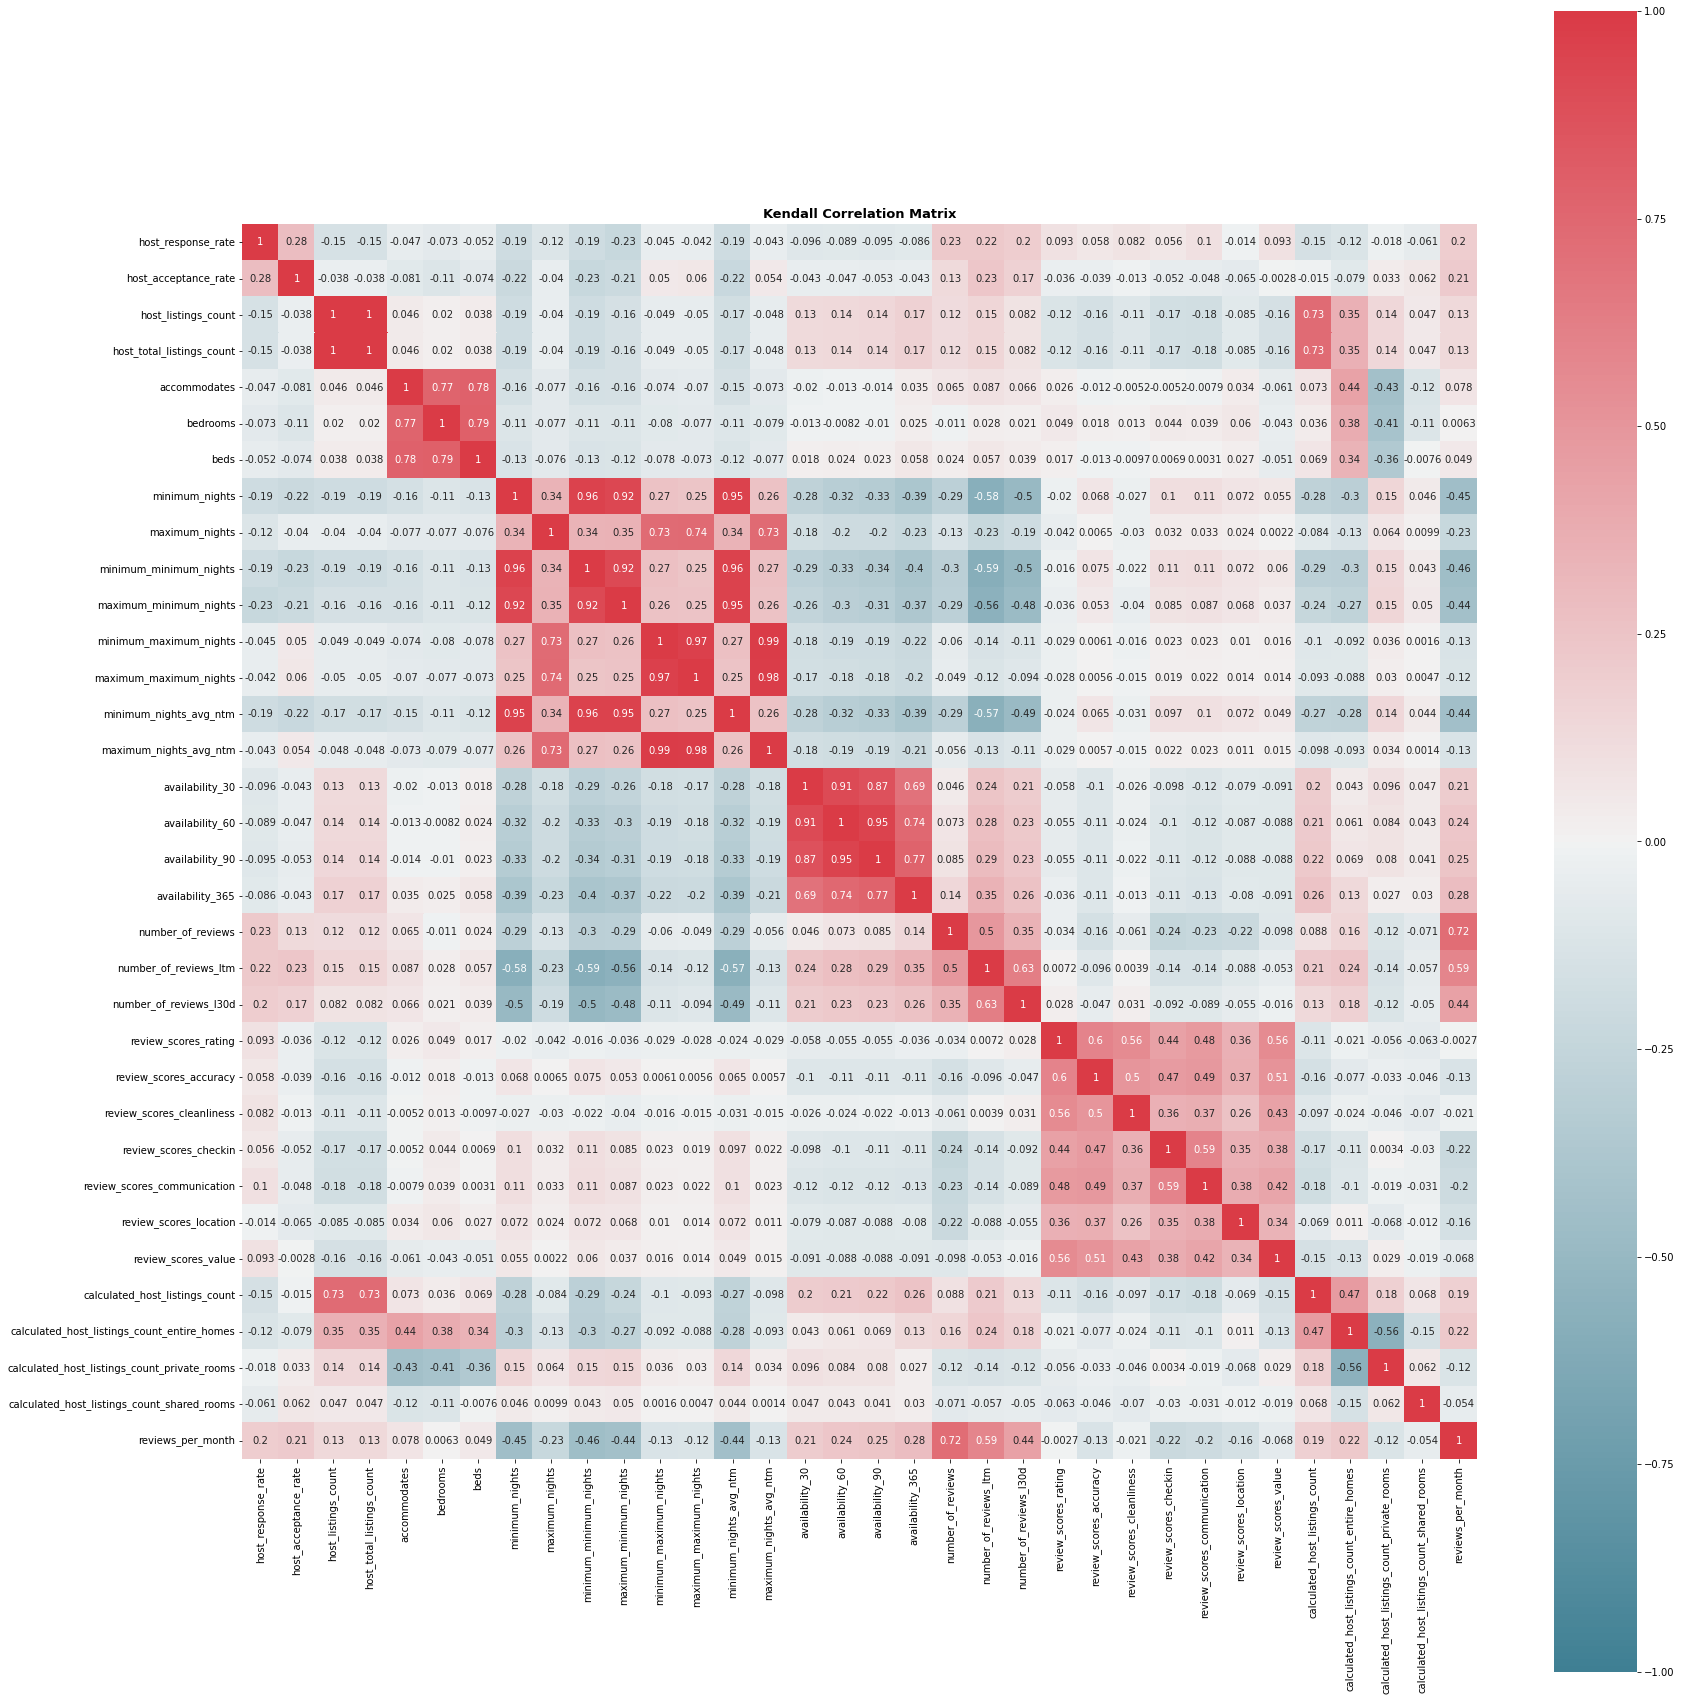

In [ ]:
# Kendall Correlation heatmap between integer features

fig, ax = plt.subplots(figsize=(25,25))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_features.corr(method = 'kendall'), vmax=1, vmin=-1, center=0, square=True, annot = True, ax=ax, cmap=cmap)
ax.set_title('Kendall Correlation Matrix', fontweight='bold', fontsize=13)
plt.tight_layout()
#plt.show()
#plt.savefig("Kendall Correlation Matrix Heatmap.png")

In [ ]:
#Pearson - measures the strength and direction of linear relationship
#Spearman - measures monotonic relationshiip (might be non-linear increase/decrease), more sensitive to errors and deviations than Kendall Tau
#KenallTau - similar to Spearman, measures monotonic relationship, but less sensitive to errors and deviations

#### Explore the Correlation between Different Availability Measures

As seen in the Pearson correlation matrix and Kendall correlation matrix, some features have a strong correlation with others. For example, different Availability measures have strong multicollinearity, as well as different Review Score measures.

The session below explores the multicollinearity between different Availability measures.

In [ ]:
avail = ['availability_30', 'availability_60',
       'availability_90', 'availability_365']
avail_df = df_nogeo[avail]

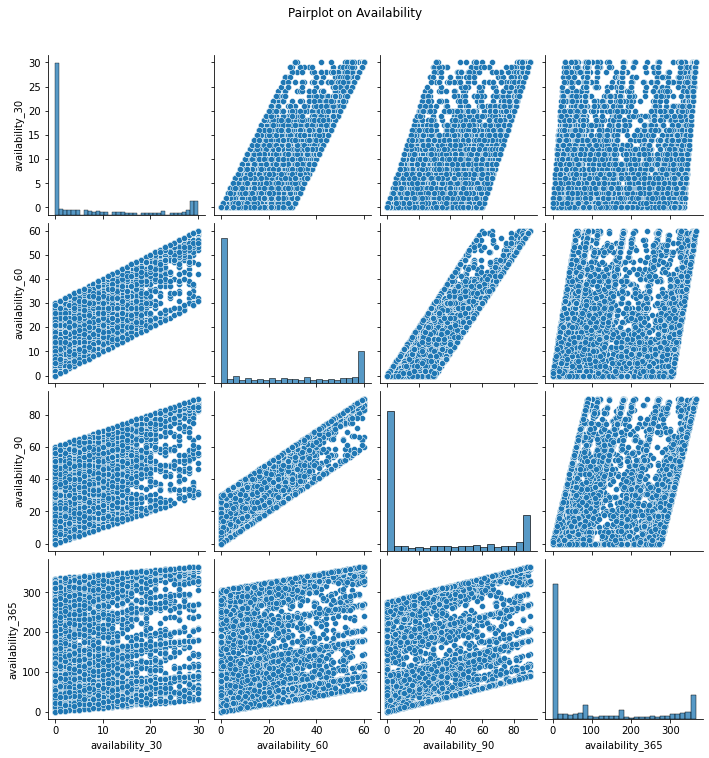

In [ ]:
#Scatter plot on different Availability measures

pairplot = sns.pairplot(avail_df)
pairplot.fig.suptitle('Pairplot on Availability', y = '1.05')
plt.show()

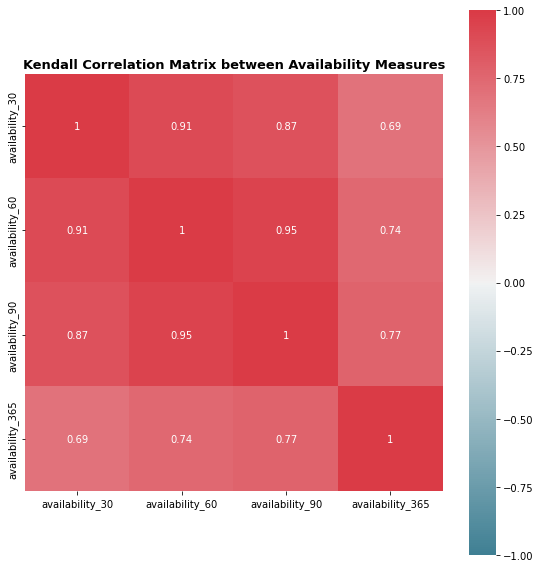

In [ ]:
# Kendall Correlation heatmap between Availability measures

fig, ax = plt.subplots(figsize=(8,8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(avail_df.corr(method = 'kendall'), vmax=1, vmin=-1, center=0, square=True, annot = True, ax=ax, cmap=cmap)
ax.set_title('Kendall Correlation Matrix between Availability Measures', fontweight='bold', fontsize=13)
plt.tight_layout()
#plt.show()
#plt.savefig("Kendall Correlation Matrix between Availability Measures.png")


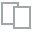
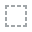
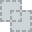
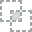
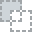
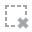
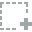
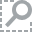
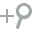
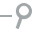
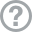
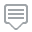
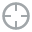
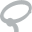
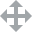
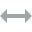
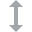
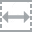
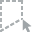
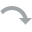
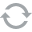
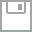
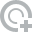
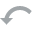
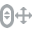
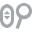
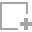
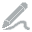
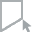
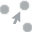
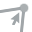
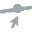

In [ ]:
avail.append('price')
plot_correlation(df_nogeo[avail], 'price')

In [ ]:
##-------------- End of Exploratory Data Analysis --------------##

## Feature Engineering ##

### Handling the missing value

In [ ]:
df_nogeo.isnull().sum().sort_values(ascending=False).head(10)

license                  13387
host_response_time       12996
host_response_rate       12996
host_acceptance_rate     12034
host_about                9656
host_neighbourhood        9028
neighborhood_overview     8291
neighbourhood             8289
review_scores_value       6432
review_scores_checkin     6428
dtype: int64

In [ ]:
# filling nulls from numerical columns with its median, and categorical with its mode

df_nogeo[list(df_num.columns)] = df_nogeo[list(df_num.columns)].fillna(value=df[list(df_num.columns)].median())
df_nogeo[list(df_cat.columns)] = df_nogeo[list(df_cat.columns)].astype('object')
df_nogeo[list(df_cat.columns)] = df_nogeo[list(df_cat.columns)].fillna(value=df[list(df_cat.columns)].mode())
df_nogeo[list(df_cat.columns)] = df_nogeo[list(df_cat.columns)].astype("category")

In [ ]:
df_nogeo['host_response_time'] = df_nogeo['host_response_time'].fillna(df_nogeo['host_response_time'].mode().values[0])

df_nogeo['host_is_superhost'] = df_nogeo['host_is_superhost'].astype('object')
df_nogeo['host_is_superhost'] = df_nogeo['host_is_superhost'].fillna(df_nogeo['host_is_superhost'].mode().values[0])
df_nogeo['host_is_superhost'] = df_nogeo['host_is_superhost'].astype('category')


df_nogeo['host_has_profile_pic'] = df_nogeo['host_has_profile_pic'].astype('object')
df_nogeo['host_has_profile_pic'] = df_nogeo['host_has_profile_pic'].fillna(df_nogeo['host_has_profile_pic'].mode().values[0])
df_nogeo['host_has_profile_pic'] = df_nogeo['host_has_profile_pic'].astype('category')

df_nogeo['host_identity_verified'] = df_nogeo['host_identity_verified'].astype('object')
df_nogeo['host_identity_verified'] = df_nogeo['host_identity_verified'].fillna(df_nogeo['host_identity_verified'].mode().values[0])
df_nogeo['host_identity_verified'] = df_nogeo['host_identity_verified'].astype('category')

In [ ]:
# check for missing values again, the values below all belong to dtype "object" and "datetime64"
# all categorical and numerical values have been imputed

null_list = df_nogeo.isnull().sum().sort_values(ascending=False)
for i in range(len(null_list)):
  if null_list[i] != 0:
    print("Variable {} has {} missing values. Dtype: {}".format(null_list.index[i], null_list[i], df_nogeo[null_list.index[i]].dtype))

Variable license has 13387 missing values. Dtype: object
Variable host_about has 9656 missing values. Dtype: object
Variable host_neighbourhood has 9028 missing values. Dtype: object
Variable neighborhood_overview has 8291 missing values. Dtype: object
Variable neighbourhood has 8289 missing values. Dtype: object
Variable last_review has 5809 missing values. Dtype: datetime64[ns]
Variable first_review has 5809 missing values. Dtype: datetime64[ns]
Variable description has 754 missing values. Dtype: object
Variable bathrooms_text has 24 missing values. Dtype: object
Variable host_location has 21 missing values. Dtype: object
Variable name has 7 missing values. Dtype: object
Variable host_name has 3 missing values. Dtype: object
Variable host_since has 3 missing values. Dtype: datetime64[ns]
Variable host_thumbnail_url has 3 missing values. Dtype: object
Variable host_picture_url has 3 missing values. Dtype: object


In [ ]:
# re-applying the code to update the respective dataframes

df_num = df_nogeo.select_dtypes(include = ['float64', 'int64'])  # numeric variables
df_cat = df_nogeo.select_dtypes(include = ['category']) # categorical variables

df_allf = df_nogeo.select_dtypes(include = ['float64', 'int64', 'category']) # all but dtype object and datetime
df_allf.describe()

host_response_rate  host_acceptance_rate  host_listings_count  \
count        20880.000000          20880.000000         20880.000000   
mean             0.963988              0.870333            10.947941   
std              0.156000              0.221098            40.990521   
min              0.000000              0.000000             0.000000   
25%              1.000000              0.940000             1.000000   
50%              1.000000              0.940000             1.000000   
75%              1.000000              0.940000             3.000000   
max              1.000000              1.000000           457.000000   

       host_total_listings_count  accommodates      bedrooms          beds  \
count               20880.000000  20880.000000  20880.000000  20880.000000   
mean                   10.947941      3.383333      1.655891      1.994828   
std                    40.990521      2.188119      1.015578      1.519411   
min                     0.000000      1.000000      1.000000      1.000000   
25%                     1.000000      2.000000      1.000000      1.000000   
50%                     1.000000      2.000000      1.000000      1.000000   
75%                     3.000000      4.000000      2.000000      2.000000   
max                   457.000000     16.000000     18.000000     39.000000   

              price  minimum_nights  maximum_nights  ...  \
count  20880.000000    20880.000000    20880.000000  ...   
mean     251.166188       62.189464      905.051006  ...   
std      498.598911       52.739348      407.076078  ...   
min       13.000000        1.000000        1.000000  ...   
25%       80.000000        4.000000     1125.000000  ...   
50%      140.000000       90.000000     1125.000000  ...   
75%      250.000000       90.000000     1125.000000  ...   
max    28613.000000     1125.000000     1500.000000  ...   

       review_scores_cleanliness  review_scores_checkin  \
count               20880.000000           20880.000000   
mean                    4.653773               4.878256   
std                     0.531008               0.375271   
min                     0.000000               0.000000   
25%                     4.670000               4.920000   
50%                     4.800000               5.000000   
75%                     4.930000               5.000000   
max                     5.000000               5.000000   

       review_scores_communication  review_scores_location  \
count                 20880.000000            20880.000000   
mean                      4.876066                4.860676   
std                       0.391744                0.326520   
min                       0.000000                0.000000   
25%                       4.930000                4.880000   
50%                       5.000000                4.960000   
75%                       5.000000                5.000000   
max                       5.000000                5.000000   

       review_scores_value  calculated_host_listings_count  \
count         20880.000000                    20880.000000   
mean              4.673112                        8.094540   
std               0.452732                       25.191637   
min               0.000000                        1.000000   
25%               4.670000                        1.000000   
50%               4.770000                        1.000000   
75%               4.880000                        3.000000   
max               5.000000                      197.000000   

       calculated_host_listings_count_entire_homes  \
count                                 20880.000000   
mean                                      6.718966   
std                                      24.134766   
min                                       0.000000   
25%                                       0.000000   
50%                                       1.000000   
75%                                       1.000000   
max                             

In [ ]:
# For boolean predictors, create a dummy variable (0 or 1) to represent True or False

labels = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'has_availability', 'instant_bookable']
for label in labels:
    df_allf[label] = pd.get_dummies(df_allf[label], drop_first=True)

In [ ]:
# Adding high cardinality variables
# Neighbourhood is treated as a categorical variable here

variable = 'neighbourhood_cleansed_aggregate'
df_allf['neighbourhood_cleansed_aggregate'] = df_nogeo['neighbourhood_cleansed']

counts = df_allf['neighbourhood_cleansed_aggregate'].value_counts()
for level in counts.index:
    if counts[level] < 250:
        df_allf.loc[df_allf[variable]==level, variable] = 'Other'

df_allf['neighbourhood_cleansed_aggregate'] = df_allf['neighbourhood_cleansed_aggregate'].fillna(value=df_allf['neighbourhood_cleansed_aggregate'].mode())

df_allf['neighbourhood_cleansed_aggregate'] = df_allf['neighbourhood_cleansed_aggregate'].astype("category")

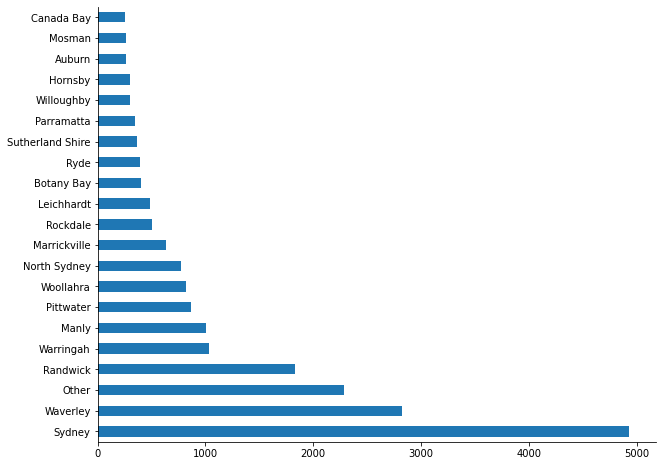

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
df_allf['neighbourhood_cleansed_aggregate'].value_counts().plot(kind='barh')
sns.despine()
plt.show()

In [ ]:
# Adding high cardinality variables
# Property type is treated as a categorical variable here

variable = 'property_type_aggregate'
df_allf['property_type_aggregate'] = df_nogeo['property_type']

counts = df_allf[variable].value_counts()
for level in counts.index:
    if counts[level] < 100:
        df_allf.loc[df_allf[variable]==level, variable] = 'Other'

df_allf['property_type_aggregate'] = df_allf['property_type_aggregate'].fillna(value=df_allf['property_type_aggregate'].mode())

df_allf['property_type_aggregate'] = df_allf['property_type_aggregate'].astype("category")

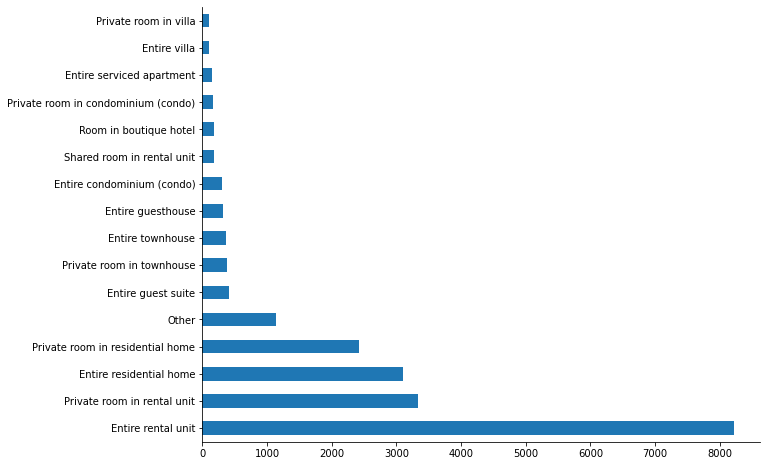

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
df_allf['property_type_aggregate'].value_counts().plot(kind='barh')
sns.despine()
plt.show()

##### We also try to predict the missing numeric values -- 'host_acceptance_rate' and 'host_response_rate', but the outcome has not improved considerably. So we decide to remove such parts, and put them in text lines.

from sklearn.model_selection import train_test_split
df_allf.reset_index()
# Convert to a pandas dataframe like in your example
icols = [
       'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'room_type',
       'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month','neighbourhood_cleansed_aggregate','property_type_aggregate']
jcols = ['host_acceptance_rate', 'host_response_rate']
df_fill_miss = df_allf.copy()
notnans = df_fill_miss[jcols].notnull().all(axis=1)
df_notnans = df_fill_miss[notnans]
X_train_miss, X_test_miss, y_train_miss, y_test_miss = train_test_split(df_notnans[icols], df_notnans[jcols],
                                                    train_size=0.75,
                                                    random_state=4)
df_miss_features = df_notnans.copy().drop(['price'], axis=1)
df_miss_response = df_notnans["price"]
X_train_miss_price, X_test_miss_price, y_train_miss_price, y_test_miss_price = train_test_split(df_miss_features, df_miss_response,
                                                    train_size=0.75,
                                                    random_state=4)
cat_predictor = ['neighbourhood_cleansed_aggregate', 'room_type', 'property_type_aggregate']

encoder = CatBoostEncoder().fit(X_train_miss_price[cat_predictor], y_train_miss_price) # we must use the training set for this
X_train_miss[cat_predictor] = encoder.transform(X_train_miss[cat_predictor])
X_test_miss[cat_predictor] = encoder.transform(X_test_miss[cat_predictor])
df_fill_miss[cat_predictor] = encoder.transform(df_fill_miss[cat_predictor])


from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split

regr_multirf = MultiOutputRegressor(RandomForestRegressor(max_depth=30,
                                                          random_state=0))

# Fit on the train data
regr_multirf.fit(X_train_miss, y_train_miss)

# Check the prediction score
score = regr_multirf.score(X_test_miss, y_test_miss)
print("The prediction score on the test data is {:.2f}%".format(score*100))
df_nans = df_fill_miss.loc[~notnans].copy()
df_nans[jcols] = regr_multirf.predict(df_nans[icols])
f_allff = pd.concat([df_nans,df_notnans],axis=0)
df_allff.rename(columns = {'host_acceptance_rate':'host_acceptance_rate_pre', 'host_response_rate':'host_response_rate_pre'}, inplace = True)
df_allf = pd.merge(df_allf,df_allff['host_acceptance_rate_pre'], left_index=True,right_index=True,how='outer')
df_allf = pd.merge(df_allf,df_allff['host_response_rate_pre'], left_index=True,right_index=True,how='outer')
df_allf.drop('host_acceptance_rate',axis=1,inplace = True)
df_allf.drop('host_response_rate',axis=1,inplace = True)

#### Transformation of Features

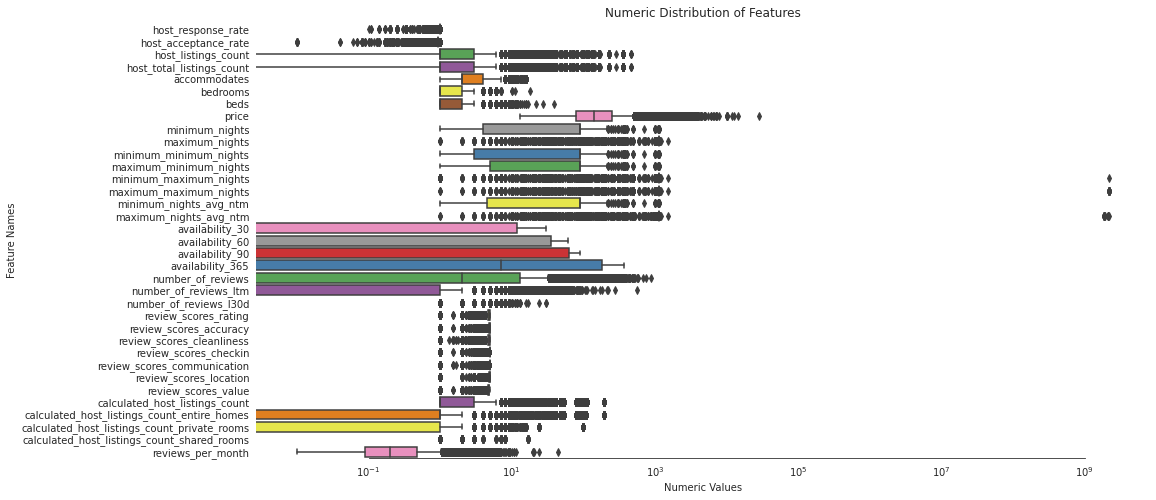

In [ ]:
# inspecting the distribution of numerical variable

sns.set_style("white")
f, ax = plt.subplots(figsize=(16, 8))
ax.set_xscale("log")
ax = sns.boxplot(data=df_allf.select_dtypes(include=["int64", "float64"]), orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature Names")
ax.set(xlabel="Numeric Values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [ ]:
# Find skewed numerical features, we want to exclude the price

skew_features = df_allf.select_dtypes(include=["int64", "float64"]).drop(columns = 'price').apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(15)

There are 24 numerical features with Skew > 0.5 :


minimum_maximum_nights                          144.488754
maximum_nights_avg_ntm                           36.310399
maximum_maximum_nights                           36.083248
calculated_host_listings_count_shared_rooms      18.726990
number_of_reviews_ltm                            16.195803
calculated_host_listings_count_private_rooms     12.545710
reviews_per_month                                 9.284515
number_of_reviews_l30d                            7.025102
host_total_listings_count                         6.581045
host_listings_count                               6.581045
calculated_host_listings_count_entire_homes       5.808849
maximum_minimum_nights                            5.583624
minimum_nights_avg_ntm                            5.473084
minimum_nights                                    5.419685
minimum_minimum_nights                            5.378297
dtype: float64

In [ ]:
# boxcox transformation of skewed features (except the price)

for i in skew_index:
    df_allf[i] = boxcox1p(df_allf[i], boxcox_normmax(df_allf[i] + 1))

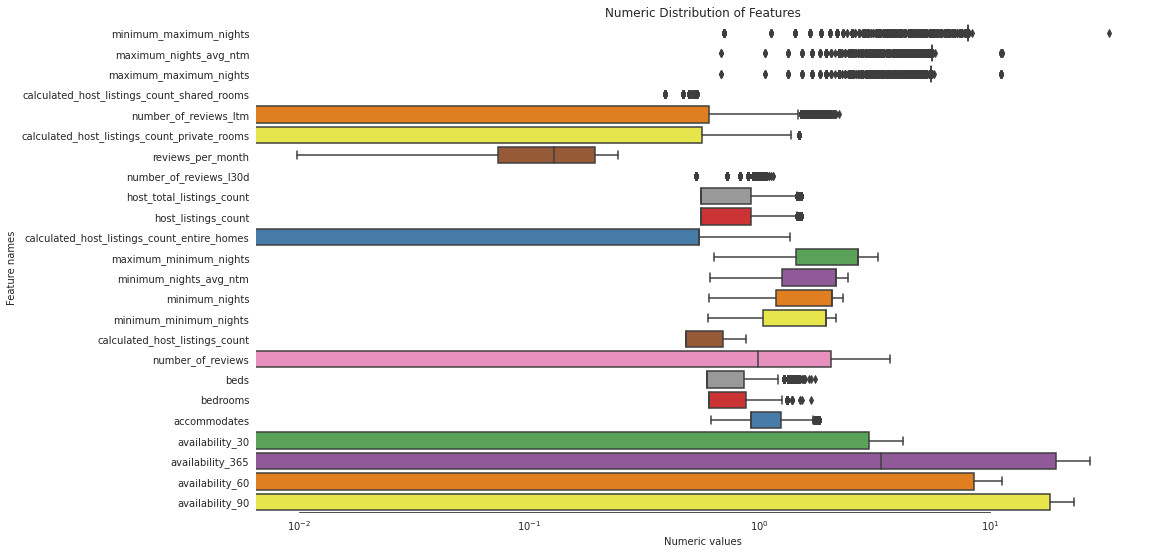

In [ ]:
# Re-checking to make sure we handled all the skewed values

sns.set_style("white")
f, ax = plt.subplots(figsize=(16, 9))
ax.set_xscale("log")
ax = sns.boxplot(data=df_allf[skew_index] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)


 mu = 5.02 and sigma = 0.89



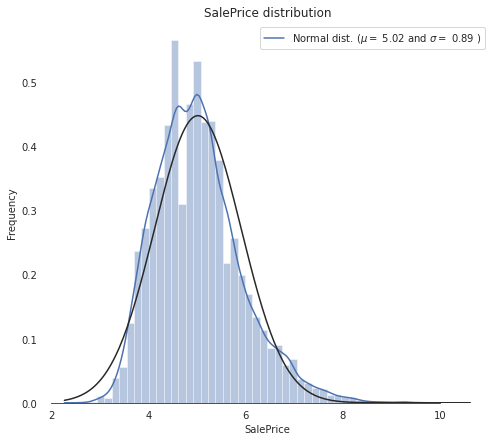

In [ ]:
# log1p transformation is applied on the response variable price

df_allf["price"] = np.log1p(df_allf["price"])
df_allf.replace(np.inf, 0, inplace = True)
df_allf.replace(-np.inf, 0, inplace = True)

# check the new distribution of response variable

sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))

sns.distplot(df_allf['price'] , fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_allf['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

In [ ]:
# dropping "host_listings_count" because it has perfect correlation with "host_total_listings_count"
# they have the exact same elements in both columns, thus one can be dropped
df_allf = df_allf.drop(["host_listings_count"],axis=1)

In [ ]:
# splitting the dataset into training (80%) and test (20%) set
# for validation set(s), it will be further split during model selection depending on the types of validation used

df_train = df_allf.sample(frac=0.8, random_state=100)
df_test = df_allf[df_allf.index.isin(df_train.index)==False]

In [ ]:
# splitting the training and testing data into features and response

train_features = df_train.copy().drop(['price'], axis=1)
test_features = df_test.copy().drop(['price'], axis=1)

train_response = df_train["price"]
test_response = df_test["price"]

In [ ]:
# Use CatBoost encoder to encode the remaining categorical variables

cat_predictor = ['neighbourhood_cleansed_aggregate', 'room_type', 'property_type_aggregate', 'host_response_time']

encoder = CatBoostEncoder().fit(train_features[cat_predictor], train_response) # we must use the training set for this
train_features[cat_predictor] = encoder.transform(train_features[cat_predictor])
test_features[cat_predictor] = encoder.transform(test_features[cat_predictor])

In [ ]:
##-------------- End of Feature Engineering --------------##

## Model 1: Linear ##

In [ ]:
def coefplot(model, labels):
    coef = model.coef_
    table = pd.Series(coef.ravel(), index = labels).sort_values(ascending=True, inplace=False)

    all_ = True
    if len(table) > 20:
        reference = pd.Series(np.abs(coef.ravel()), index = labels).sort_values(ascending=False, inplace=False)
        reference = reference.iloc[:20]
        table = table[reference.index]
        table = table.sort_values(ascending=True, inplace=False)
        all_ = False


    fig, ax = plt.subplots(figsize=(10,8))
    table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0)
    if all_:
        ax.set_title('Estimated coefficients', fontsize=14)
    else:
        ax.set_title('Estimated coefficients (20 largest in absolute value)', fontsize=14)
    sns.despine()
    return fig, ax

In [ ]:
train_response_linear = train_response.copy()
test_response_linear = test_response.copy()
train_features_linear = train_features.copy()
test_features_linear = test_features.copy()

### Linear Regression

In [ ]:
#linear regression
linear = LinearRegression()
linear.fit(train_features_linear, train_response_linear)

LinearRegression()

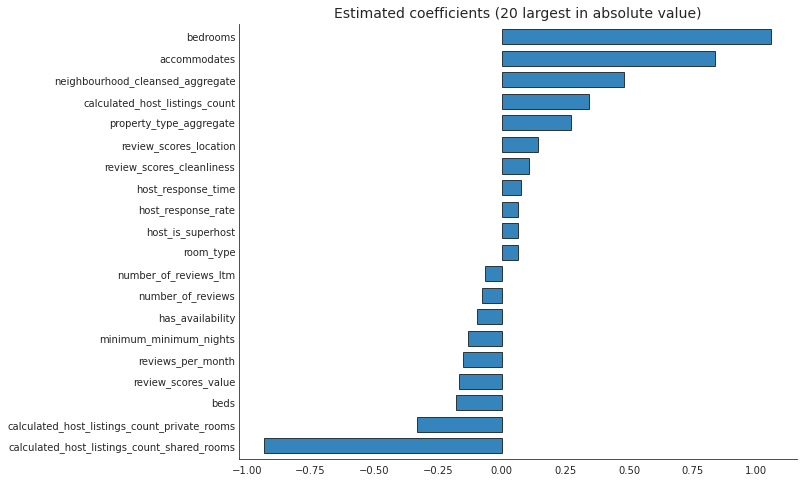

In [ ]:
coefplot(linear, list(train_features_linear.columns))
plt.show()

### Ridge

In [ ]:
ridge = RidgeCV(normalize = True, cv = 10)
ridge.fit(train_features_linear, train_response_linear)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=10, normalize=True)

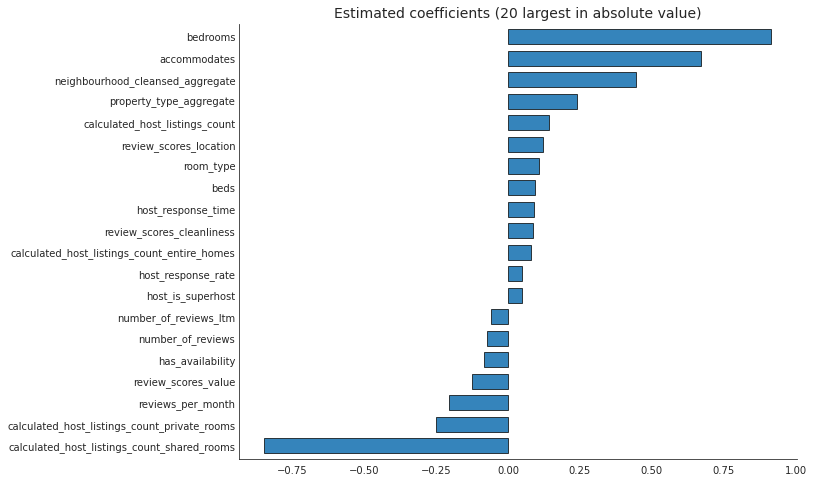

In [ ]:
coefplot(ridge, list(train_features_linear.columns))
plt.show()

### LASSO

In [ ]:
mu_lasso = train_features_linear.mean() # mean for each feature
sigma_lasso = train_features_linear.std() # std for each feature
train_features_lasso = (train_features_linear-mu_lasso)/sigma_lasso #standardise data for lasso
train_features_lasso = train_features_lasso.fillna(0)
test_features_lasso = (test_features_linear-mu_lasso)/sigma_lasso
test_features_lasso = test_features_lasso.fillna(0)

In [ ]:
lasso = LassoCV(cv=10, random_state=1, max_iter = 2000)
lasso.fit(train_features_lasso, train_response_linear)

LassoCV(cv=10, max_iter=2000, random_state=1)

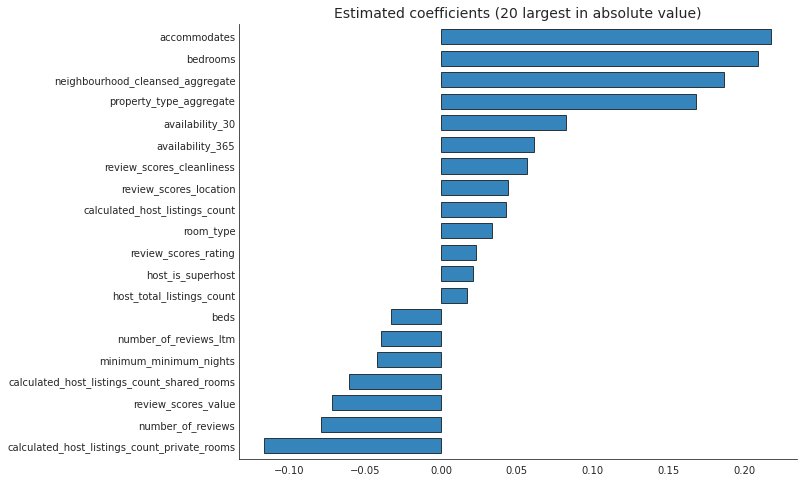

In [ ]:
coefplot(lasso, list(train_features_lasso.columns))
plt.show()

In [ ]:
lasso_coef = pd.DataFrame(lasso.coef_.round(3), index = list(train_features_lasso.columns)).T
lasso_coef.loc[:, (lasso_coef == 0).all()]

host_acceptance_rate  minimum_nights  maximum_nights  \
0                  -0.0             0.0             0.0   

   minimum_nights_avg_ntm  maximum_nights_avg_ntm  availability_60  \
0                    -0.0                    -0.0              0.0   

   availability_90  review_scores_communication  \
0             -0.0                          0.0   

   calculated_host_listings_count_entire_homes  
0                                          0.0

### Linear Model Predictions

In [ ]:
columns=['Test RMSE', 'Test R\u00b2', 'Test MAE','Test RMSE on actual values']
rows=["linear", "ridge", "lasso"]

results1=pd.DataFrame(0.0, columns=columns, index=rows)

methods = [linear,ridge,lasso]

for i, method in enumerate(methods):
    if i == 2:
        y_pred = method.predict(test_features_lasso)
    else:
        y_pred = method.predict(test_features_linear)

    results1.iloc[i,0] = np.sqrt(mean_squared_error(test_response_linear,y_pred))
    results1.iloc[i,1] = r2_score(test_response_linear, y_pred)
    results1.iloc[i,2] = mean_absolute_error(test_response_linear, y_pred)
    results1.iloc[i,3] = np.sqrt(mean_squared_error(np.expm1(test_response_linear), np.expm1(y_pred)))

results1.round(4)

Test RMSE  Test R²  Test MAE  Test RMSE on actual values
linear     0.4957   0.6899    0.3678                    386.5119
ridge      0.4993   0.6854    0.3711                    392.5573
lasso      0.4959   0.6897    0.3678                    387.0839

## Model 2: Tree-Based ##

In [ ]:
train_response_tree = train_response.copy()
test_response_tree = test_response.copy()
train_features_tree = train_features.copy()
test_features_tree = test_features.copy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_features_tree, train_response_tree, test_size=0.33, random_state=42)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test,y_test)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 30,
    'learning_rate': 0.01,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100000,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=10000)])

y_pred = gbm.predict(test_features_tree, num_iteration=gbm.best_iteration)
rmse_test = mean_squared_error(test_response_tree, y_pred) ** 0.5
print(rmse_test)

Streaming output truncated to the last 5000 lines.
[8548]	valid_0's rmse: 0.459451
[8549]	valid_0's rmse: 0.459449
[8550]	valid_0's rmse: 0.459452
[8551]	valid_0's rmse: 0.459448
[8552]	valid_0's rmse: 0.459453
[8553]	valid_0's rmse: 0.459453
[8554]	valid_0's rmse: 0.45945
[8555]	valid_0's rmse: 0.459454
[8556]	valid_0's rmse: 0.459458
[8557]	valid_0's rmse: 0.459457
[8558]	valid_0's rmse: 0.459463
[8559]	valid_0's rmse: 0.459462
[8560]	valid_0's rmse: 0.459464
[8561]	valid_0's rmse: 0.459464
[8562]	valid_0's rmse: 0.459462
[8563]	valid_0's rmse: 0.459461
[8564]	valid_0's rmse: 0.459463
[8565]	valid_0's rmse: 0.459464
[8566]	valid_0's rmse: 0.459459
[8567]	valid_0's rmse: 0.459448
[8568]	valid_0's rmse: 0.459443
[8569]	valid_0's rmse: 0.459436
[8570]	valid_0's rmse: 0.459429
[8571]	valid_0's rmse: 0.459428
[8572]	valid_0's rmse: 0.459426
[8573]	valid_0's rmse: 0.459428
[8574]	valid_0's rmse: 0.459434
[8575]	valid_0's rmse: 0.459431
[8576]	valid_0's rmse: 0.459433
[8577]	valid_0's rmse:

In [ ]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor()
scores = cross_val_score(xg_reg, train_features_tree,train_response_tree, scoring = 'neg_root_mean_squared_error',n_jobs = -1,cv = 10)
print(np.mean(scores), np.std(scores))
print(scores)

-0.467384437604923 0.015371460771034897
[-0.4569853  -0.44928295 -0.48848288 -0.46539709 -0.48916237 -0.46550902
 -0.45262257 -0.44824737 -0.47063552 -0.48751931]


In [ ]:
def return_score_xgb(param):
    model = xgb.XGBRegressor(**param)
    rmse = -np.mean(cross_val_score(model,train_features_tree,train_response_tree,cv = 5, n_jobs =-1,scoring='neg_root_mean_squared_error'))
    return rmse

In [ ]:
def objective(trial):
    param = {
                "n_estimators" : trial.suggest_int('n_estimators', 500, 1000),
                'max_depth':trial.suggest_int('max_depth', 3, 5),
                'reg_alpha':trial.suggest_uniform('reg_alpha',0,6),
                'reg_lambda':trial.suggest_uniform('reg_lambda',0,2),
                'min_child_weight':trial.suggest_int('min_child_weight',0,5),
                'gamma':trial.suggest_uniform('gamma', 0, 4),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.1,0.2),
                'colsample_bytree':trial.suggest_uniform('colsample_bytree',0.4,0.9),
                'subsample':trial.suggest_uniform('subsample',0.4,0.9),
                'nthread' : -1
            }
    return(return_score_xgb(param)) # this will return the rmse score

In [ ]:
# may run up to half an hour to one hour, depending on computing power
# cell will be commented out for quicker/smoother run, but results may differ slightly

# study1 = optuna.create_study(direction='minimize',sampler=TPESampler())
# study1.optimize(objective, n_trials=100,show_progress_bar = True)
# study1.best_params

In [ ]:
# results showing the difference in rmse with and without tuning
# without tuning: 0.4687
# with tuning: 0.4480

# params = {}
# print(f"without tuning {return_score_xgb(params)}")
# print(f"with tuning {return_score_xgb(study1.best_params)}")

In [ ]:
# xgboost = xgb.XGBRegressor(**study1.best_params)
# xgboost.fit(train_features_tree, train_response_tree)
# optuna.visualization.plot_slice(study1)

In [ ]:
# the optimization part of random forest takes much time, so they will be commented out

# def return_score_rf(param):
#     model = RandomForestRegressor(**param)
#     rmse = -np.mean(cross_val_score(model,train_features_tree,train_response_tree,cv = 5, n_jobs =-1,scoring='neg_root_mean_squared_error'))
#     return rmse

# def objective2(trial):
#     param = {
#             "n_estimators" : trial.suggest_int('n_estimators', 1000, 1500),
#             'max_depth':trial.suggest_int('max_depth', 10, 20),
#             'min_samples_leaf':trial.suggest_int('min_samples_leaf', 5, 10),
#             'min_samples_split':trial.suggest_int('min_samples_split', 3, 5)
#             }
#     return(return_score_rf(param))

# study2 = optuna.create_study(direction='minimize',sampler=TPESampler())
# study2.optimize(objective2, n_trials=20,show_progress_bar = True)
# study2.best_params

# params = {}
# print(f"without tuning {return_score_rf(params)}")
# print(f"with tuning {return_score_rf(study2.best_params)}")

In [ ]:
# Light Gradient Boosting Regressor
lightgbm = lgb.LGBMRegressor(objective='regression',
                       num_leaves=6,
                       learning_rate=0.01,
                       n_estimators=7000,
                       max_bin=200,
                       bagging_fraction=0.8,
                       bagging_freq=4,
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

In [ ]:
# XGBoost Regressor
# comment this cell out instead, if performed tuning earlier

xgboost = xgb.XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       verbosity = 0,
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

In [ ]:
# fitting the data

xgboost.fit(train_features_tree, train_response_tree)
lightgbm.fit(train_features_tree, train_response_tree)
rf.fit(train_features_tree, train_response_tree)

RandomForestRegressor(max_depth=15, max_features=None, min_samples_leaf=5,
                      min_samples_split=5, n_estimators=1200, oob_score=True,
                      random_state=42)

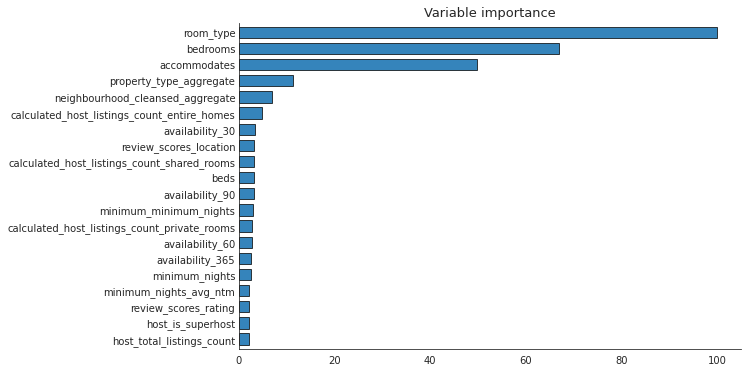

In [ ]:
from tutorial9 import plot_feature_importance

# xgboost feature importance

plot_feature_importance(xgboost, labels=train_features_tree.columns)
plt.show()

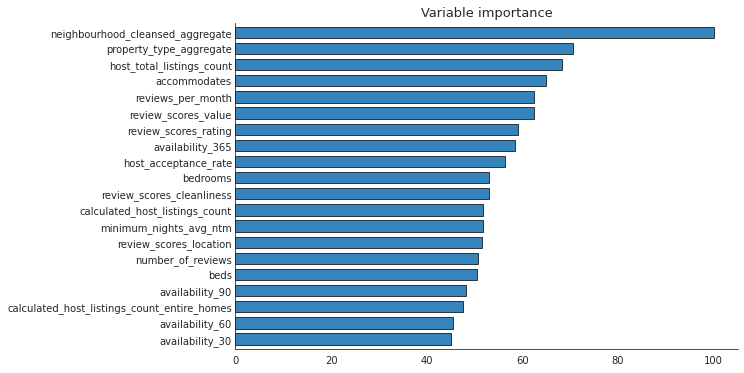

In [ ]:
# lightgbm feature importance

plot_feature_importance(lightgbm, labels=train_features_tree.columns)
plt.show()

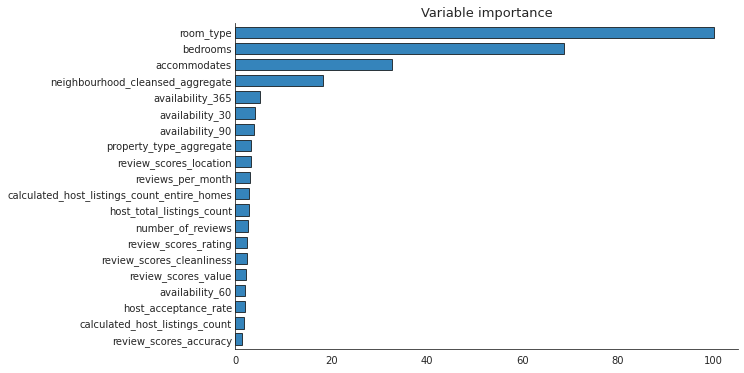

In [ ]:
# random forests feature importance

plot_feature_importance(rf, labels=train_features_tree.columns)
plt.show()

In [ ]:
columns=['Test RMSE', 'Test R\u00b2', 'Test MAE','Test RMSE on actual values']
rows=['LightGBM', "XGBoost", "Random Forests"]

results2=pd.DataFrame(0.0, columns=columns, index=rows)

methods = [lightgbm, xgboost, rf]

for i, method in enumerate(methods):

    y_pred = method.predict(test_features_tree)

    results2.iloc[i,0] = np.sqrt(mean_squared_error(test_response_tree, y_pred))
    results2.iloc[i,1] = r2_score(test_response_tree, y_pred)
    results2.iloc[i,2] = mean_absolute_error(test_response_tree, y_pred)
    results2.iloc[i,3] = np.sqrt(mean_squared_error(np.expm1(test_response_tree), np.expm1(y_pred)))

results2.round(4)

Test RMSE  Test R²  Test MAE  Test RMSE on actual values
LightGBM           0.4447   0.7504    0.3227                    345.3431
XGBoost            0.4410   0.7546    0.3181                    334.4902
Random Forests     0.4618   0.7308    0.3338                    349.2299

## Model 3: Neural Network ##

In [ ]:
# we will be using the pytorch library for neural network regression

from torch import nn
from torch.utils.data import DataLoader

In [ ]:
# some data processing for the neural network model to work correctly

train_features_nn = train_features.copy().to_numpy()
test_features_nn = test_features.copy().to_numpy()

train_response_nn = train_response.copy().to_numpy()
test_response_nn = test_response.copy().to_numpy()

In [ ]:
class BNBDataset(torch.utils.data.Dataset):

    def __init__(self, X, y, scale_data=True):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i,:], self.y[i]

In [ ]:
class NeuralNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(42, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )


    def forward(self, features):
        return self.layers(features).flatten() # returns a flat array as desired

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dfn = NeuralNetwork().to(device)

print(dfn)

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=42, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [ ]:
def train_loop(dataloader, model, loss_fn, optimiser):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    n_batches = len(dataloader)
    n_obs = len(dataloader.dataset)

    for batch, (features, response) in enumerate(dataloader):

        # Move data to GPU, if available
        features = features.to(device)
        response  = response.to(device)

        # Compute the predictions (forward pass)
        prediction = model(features)

        # Evaluate cost function
        loss = loss_fn(prediction, response)

        # Compute gradient (backward pass)
        optimiser.zero_grad()
        loss.backward()

        # Update parameters
        optimiser.step()

        # Print progress
        if batch % int(np.floor(0.2*n_batches)) == 0:
            loss, current = loss.item(), batch * len(response)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{n_obs:>5d}]")

In [ ]:
def validation(model):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Predicted probabilities
    # the .cpu().detach().numpy() part transfers the result the cpu and converts it to a numpy array
    with torch.no_grad():
        y_pred = model(torch.from_numpy(test_features_nn).float().to(device)).cpu().detach().numpy()

    # Metrics
    rmse_nn = np.sqrt(mean_squared_error(test_response_nn, y_pred))
    r2_nn = r2_score(test_response_nn, y_pred)
    mae_nn = mean_absolute_error(test_response_nn, y_pred)

    print('')
    print('Validation metrics \n')
    print(f"RMSE: {np.round(rmse_nn, 4)}")
    print(f"R^2: {np.round(r2_nn, 4)}")
    print(f"MAE: {np.round(mae_nn, 4)}")

In [ ]:
train_data = BNBDataset(train_features_nn, train_response_nn)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size = 128, shuffle=True)

In [ ]:
X, y = next(iter(train_loader))

In [ ]:
epochs = 100
learning_rate = 1e-3

loss_fn = nn.MSELoss()
optimiser = torch.optim.Adam(dfn.parameters(), lr = learning_rate) # Adam tends to work well as a default

for i in range(epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loop(train_loader, dfn, loss_fn, optimiser)
    validation(dfn)

print("Done!")

Epoch 1
-------------------------------
Loss: 219.682770  [    0/16704]
Loss: 2.729579  [ 3328/16704]
Loss: 1.158930  [ 6656/16704]
Loss: 0.892922  [ 9984/16704]
Loss: 0.549532  [13312/16704]
Loss: 0.448490  [ 8320/16704]

Validation metrics 

RMSE: 0.8435
R^2: 0.1023
MAE: 0.6319
Epoch 2
-------------------------------
Loss: 0.699507  [    0/16704]
Loss: 0.584455  [ 3328/16704]
Loss: 0.744202  [ 6656/16704]
Loss: 0.645029  [ 9984/16704]
Loss: 0.706556  [13312/16704]
Loss: 0.414904  [ 8320/16704]

Validation metrics 

RMSE: 0.8333
R^2: 0.1239
MAE: 0.7043
Epoch 3
-------------------------------
Loss: 0.905465  [    0/16704]
Loss: 0.626579  [ 3328/16704]
Loss: 0.535037  [ 6656/16704]
Loss: 0.330590  [ 9984/16704]
Loss: 0.500666  [13312/16704]
Loss: 0.423403  [ 8320/16704]

Validation metrics 

RMSE: 0.7413
R^2: 0.3065
MAE: 0.6221
Epoch 4
-------------------------------
Loss: 0.615801  [    0/16704]
Loss: 0.611066  [ 3328/16704]
Loss: 0.313859  [ 6656/16704]
Loss: 0.461955  [ 9984/16704]
L

In [ ]:
columns=['Test RMSE', 'Test R\u00b2', 'Test MAE','Test RMSE on actual values']
rows=["Neural Network"]

results3=pd.DataFrame(0.0, columns=columns, index=rows)

methods = [nn]

for i, method in enumerate(methods):

    y_pred = dfn(torch.from_numpy(test_features_nn).float().to(device)).cpu().detach().numpy()

    results3.iloc[i,0] = np.sqrt(mean_squared_error(test_response_nn, y_pred))
    results3.iloc[i,1] = r2_score(test_response_nn, y_pred)
    results3.iloc[i,2] = mean_absolute_error(test_response_nn, y_pred)
    results3.iloc[i,3] = np.sqrt(mean_squared_error(np.expm1(test_response_nn), np.expm1(y_pred)))

results3.round(4)

Test RMSE  Test R²  Test MAE  Test RMSE on actual values
Neural Network     0.5043   0.6791    0.3836                    380.1261

# Model 4: Generalised Additive Models

In [ ]:
train_response_gam = train_response.copy()
test_response_gam = test_response.copy()
train_features_gam = train_features.copy()
test_features_gam = test_features.copy()

## Analysis before modelling

In [ ]:
def plotregressions(X, y, lowess=False):
    # X should be a pandas dataframe

    colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F',
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']

    # Feature names
    labels = list(X.columns)

    n, p = X.shape

    # We want three plots per column, calculate the required number of rows accordingly
    rows = int(np.ceil(p/3))

    # Create a plot grid
    fig, axes = plt.subplots(rows, 3, figsize=(12, rows*(12/4)))

    # Loop over the plot grid, create
    for i, ax in enumerate(fig.axes):
        if i < p:

            # Scatter plot with local smoothing
            sns.regplot(X.iloc[:, i], y,  ci=None, y_jitter=0.05,
                        scatter_kws={'s': 25, 'alpha':.8}, ax=ax, lowess=lowess, color=colours[i % 10])

            # Remove axis labels to de-clutter the plot
            ax.set_xlabel('')
            ax.set_ylabel('')

            # Manually set the limits for the horizontal axis since the default doesn't work so well
            xmin = X.iloc[:,i].min()
            xmax = X.iloc[:,i].max()
            ax.set_xlim(xmin - (xmax-xmin)*0.05, xmax + (xmax - xmin)*0.05)

            # Use the feature name for the title
            ax.set_title(labels[i])

        else:
            # Delete unnecessary subplots (last row)
            fig.delaxes(ax)

    sns.despine()
    plt.tight_layout()

    return fig, axes

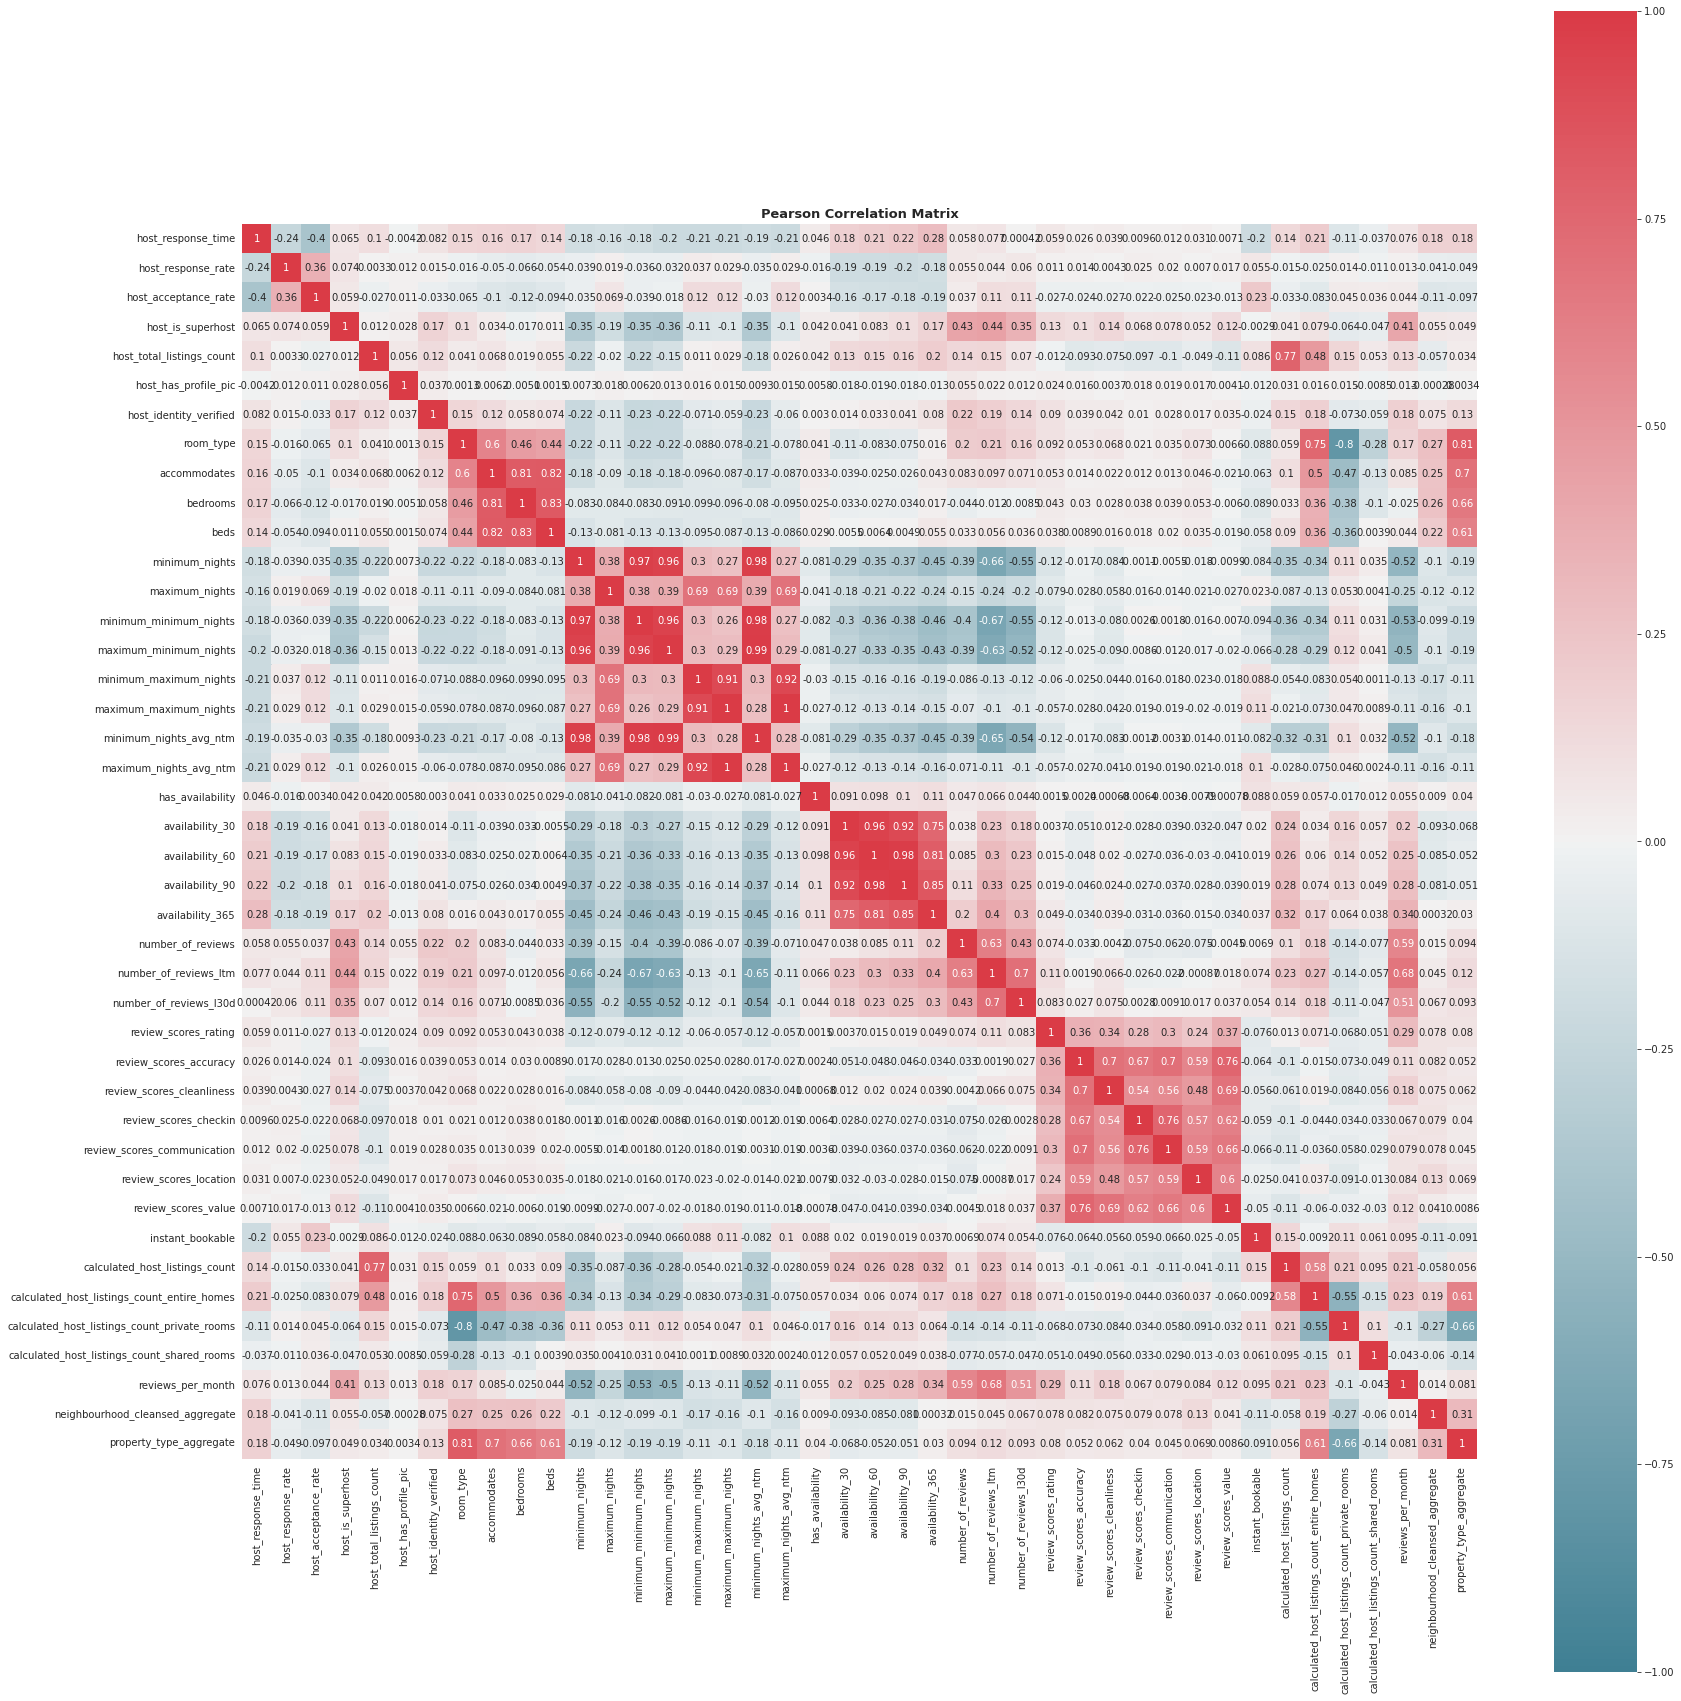

In [ ]:
fig, ax = plt.subplots(figsize=(25,25))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(train_features_gam.corr(), vmax=1, vmin=-1, center=0, square=True, annot = True, ax=ax, cmap=cmap)
ax.set_title('Pearson Correlation Matrix', fontweight='bold', fontsize=13)
plt.tight_layout()

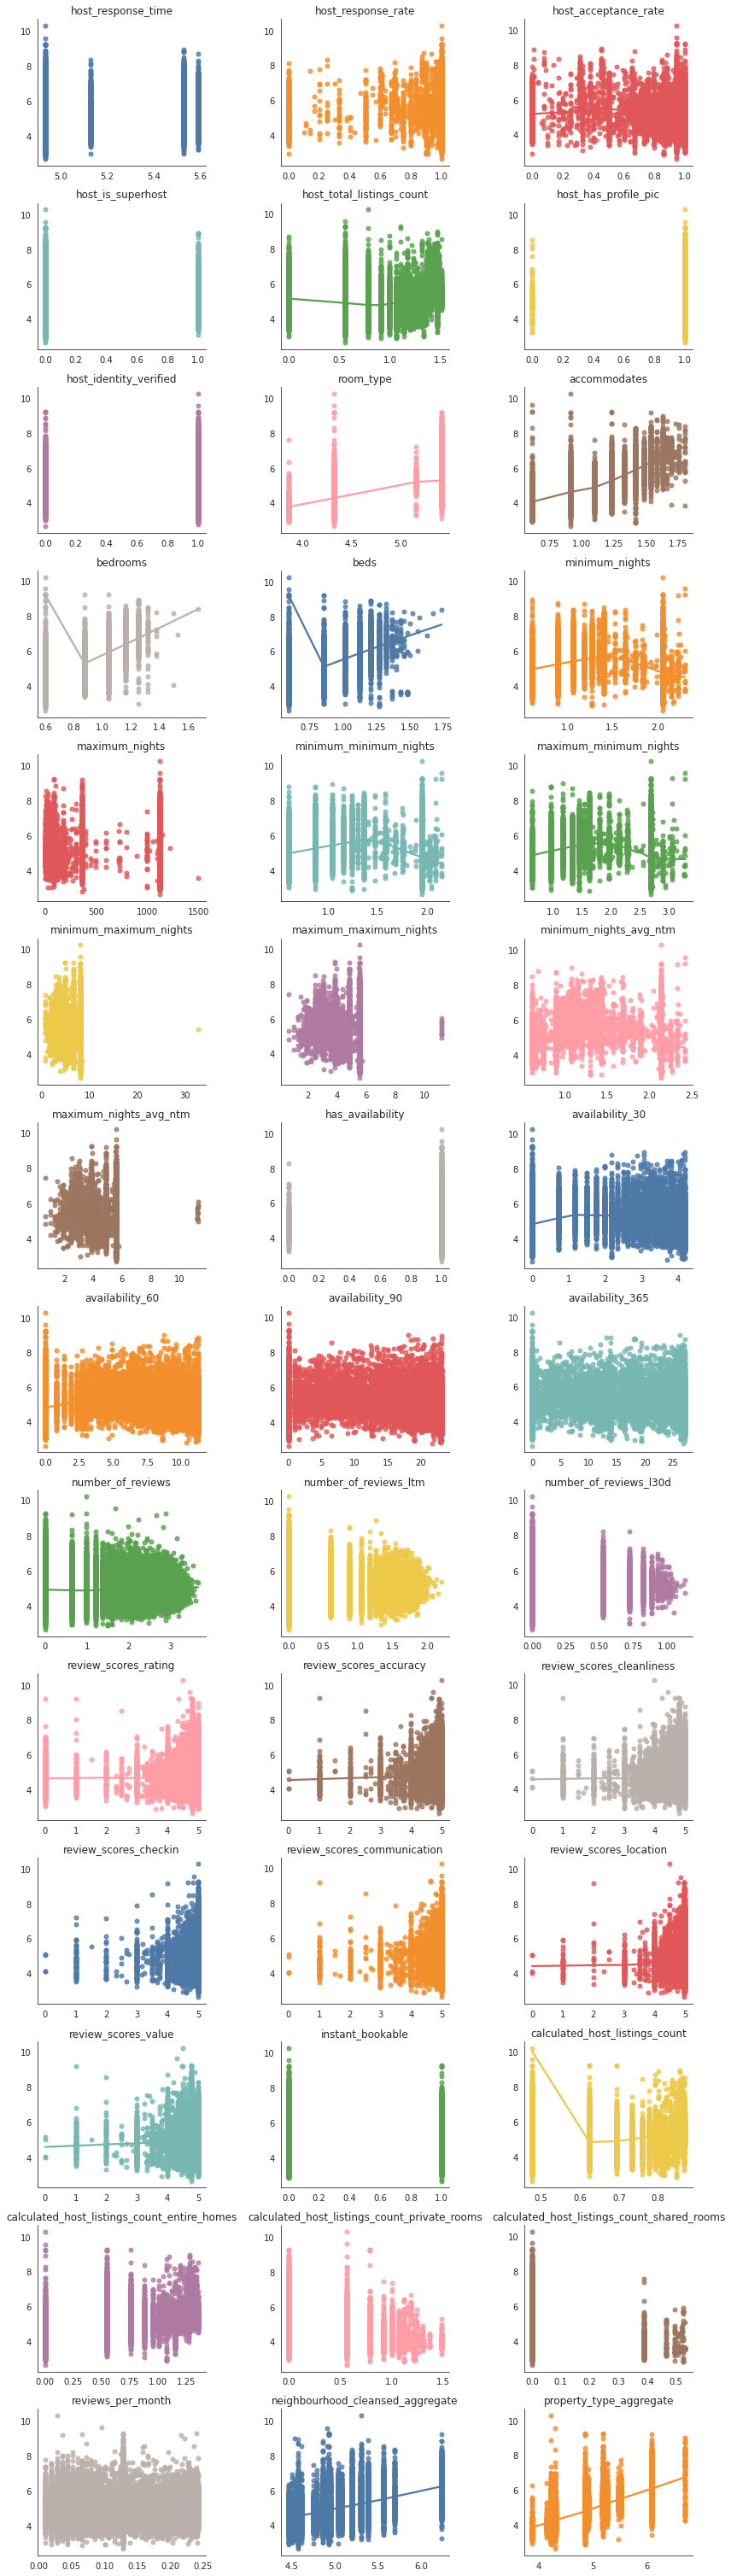

In [ ]:
plotregressions(train_features_gam, train_response_gam, lowess=True)
plt.show()

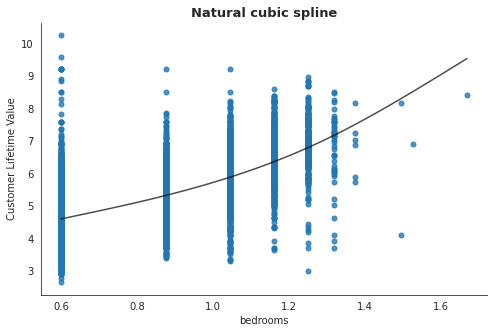

In [ ]:
from patsy import dmatrix, build_design_matrices

predictor = 'bedrooms'
X = dmatrix('cr(variable, df=3) - 1', {'variable': train_features_gam[predictor]})

ols = LinearRegression()
ols.fit(X, train_response_gam)

xmin = train_features_gam[predictor].min()
xmax = train_features_gam[predictor].max()
x = np.linspace(xmin, xmax)

XX = build_design_matrices([X.design_info], {'variable': x})[0]
y_fitted = ols.predict(XX)

fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train_features_gam[predictor], train_response_gam,  scatter_kws = {'s': 25}, fit_reg=False)
ax.plot(x, y_fitted, color='Black', alpha=0.7)
ax.set_ylabel('Customer Lifetime Value')
ax.set_title('Natural cubic spline', fontsize=13, fontweight='bold')

sns.despine()
plt.show()

In [ ]:
from pygam import LinearGAM, s, f, l, te
gam = LinearGAM(f(0) + l(1) + s(2) + l(3) + l(4) + l(5) + l(6) + f(7) + te(8,9,10)+ l(11)+l(12)+l(13)+l(14)+l(15)+l(16)+l(17)+l(18) + l(19) + l(20)+l(21)+l(22)+l(23) + l(24) + l(25)+l(26)+l(27)+l(28)+l(29)+l(30) + l(31) + l(32) + l(33) + l(34) + l(35) + l(36) + l(37) + l(38)+ l(39) + f(40) + f(41))

In [ ]:
from optuna.samplers import TPESampler

def objective(trial):

    lambdas = []
    for j in range(42):
        lambdas.append(trial.suggest_loguniform(f'lambda_{j}', 1e-4, 10000.0))

    model = LinearGAM(f(0) + l(1) + s(2) + l(3) + l(4) + l(5) + l(6) + f(7) + te(8,9,10)+ l(11)+l(12)+l(13)+l(14)+l(15)+l(16)+l(17)+l(18) + l(19) + l(20)+l(21)+l(22)+l(23) + l(24) + l(25)+l(26)+l(27)+l(28)+l(29)+l(30) + l(31) + l(32) + l(33) + l(34) + l(35) + l(36) + l(37) + l(38)+ l(39) + f(40) + f(41), lam = lambdas)
    model.fit(train_features_gam, train_response_gam)

    return model.statistics_['GCV']

sampler = TPESampler(seed=42)  # makes the sampler behave in a deterministic way
study = optuna.create_study(direction='minimize', sampler=sampler) # TPE is a method for Bayesian optimisation
study.optimize(objective, n_trials=10000, timeout=120)

[I 2022-05-26 20:01:08,731] A new study created in memory with name: no-name-15694852-e36e-4272-a420-ea7f35dc5670
[I 2022-05-26 20:01:26,771] Trial 0 finished with value: 0.2373956378379468 and parameters: {'lambda_0': 0.09915644566638401, 'lambda_1': 4033.8008326003933, 'lambda_2': 71.77141927992021, 'lambda_3': 6.155564318973028, 'lambda_4': 0.0017707168643537846, 'lambda_5': 0.0017699302940633358, 'lambda_6': 0.00029152036385288323, 'lambda_7': 849.9808989183019, 'lambda_8': 6.4405075539937195, 'lambda_9': 46.19347374377384, 'lambda_10': 0.00014610865886287216, 'lambda_11': 5744.851636320435, 'lambda_12': 456.6054873446131, 'lambda_13': 0.004997040685255816, 'lambda_14': 0.002848391870910803, 'lambda_15': 0.0029324868872723803, 'lambda_16': 0.027160511446548512, 'lambda_17': 1.5777981883365035, 'lambda_18': 0.2854697857797185, 'lambda_19': 0.02137140731637301, 'lambda_20': 7.849159562555091, 'lambda_21': 0.001306023180353164, 'lambda_22': 0.02173487707341741, 'lambda_23': 0.08528933

In [ ]:
lambdas = list(study.best_params.values())

gam = LinearGAM(f(0) + l(1) + s(2) + l(3) + l(4) + l(5) + l(6) + f(7) + te(8,9,10)+ l(11)+l(12)+l(13)+l(14)+l(15)+l(16)+l(17)+l(18) + l(19) + l(20)+l(21)+l(22)+l(23) + l(24) + l(25)+l(26)+l(27)+l(28)+l(29)+l(30) + l(31) + l(32) + l(33) + l(34) + l(35) + l(36) + l(37) + l(38)+ l(39) + f(40) + f(41), lam = lambdas)
gam.fit(train_features_gam, train_response_gam)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=f(0) + l(1) + s(2) + l(3) + l(4) + l(5) + l(6) + f(7) + te(8, 9, 10) + l(11) + l(12) + l(13) + l(14) + l(15) + l(16) + l(17) + l(18) + l(19) + l(20) + l(21) + l(22) + l(23) + l(24) + l(25) + l(26) + l(27) + l(28) + l(29) + l(30) + l(31) + l(32) + l(33) + l(34) + l(35) + l(36) + l(37) + l(38) + l(39) + f(40) + f(41) + intercept,
   tol=0.0001, verbose=False)

In [ ]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      92.858
Link Function:                     IdentityLink Log Likelihood:                                -26698.6791
Number of Samples:                        16704 AIC:                                            53585.0743
                                                AICc:                                           53586.1464
                                                GCV:                                                0.2349
                                                Scale:                                              0.2326
                                                Pseudo R-Squared:                                   0.7087
Feature Function                  Lam

In [ ]:
# Initialise table
columns=['Test RMSE', 'Test R\u00b2', 'Test MAE','Test RMSE on actual values']
rows=['GAM']
results4 =pd.DataFrame(0.0, columns=columns, index=rows)

# List algorithms
methods = [gam]

# Computer test predictions and metrics
for i, method in enumerate(methods):

    y_pred = method.predict(test_features_gam)

    results4.iloc[i, 0] = np.sqrt(mean_squared_error(test_response, y_pred))
    results4.iloc[i, 1] = r2_score(test_response, y_pred)
    results4.iloc[i, 2] = mean_absolute_error(test_response, y_pred)
    results4.iloc[i, 3] = np.sqrt(mean_squared_error(np.expm1(test_response_gam), np.expm1(y_pred)))

results4.round(4)

Test RMSE  Test R²  Test MAE  Test RMSE on actual values
GAM     0.4773   0.7126     0.352                    361.1443

# Model 5: Model Stack

In [ ]:
train_response_stack = train_response.copy()
test_response_stack = test_response.copy()
train_features_stack = train_features.copy()
test_features_stack = test_features.copy()

In [ ]:
clfs = [linear,
        xgboost,
        nn,
        gam
]

In [ ]:
X_train_stack  = np.zeros((train_features_stack.shape[0], len(clfs)))
X_test_stack = np.zeros((test_features_stack.shape[0], len(clfs)))
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=False)
for i,clf in enumerate(clfs):
    if i == 2:
        for train_index,test_index in kf.split(train_features_stack):
            X_train_stack[test_index,i] = dfn(torch.from_numpy(train_features_stack.iloc[test_index].to_numpy()).float().to(device)).cpu().detach().numpy()
    else:
        for train_index,test_index in kf.split(train_features_stack):
            tr_x = train_features_stack.iloc[train_index]
            tr_y = train_response_stack.iloc[train_index]
            clf.fit(tr_x,tr_y)
            X_train_stack[test_index,i] = clf.predict(train_features_stack.iloc[test_index])

In [ ]:
clf_second = LinearRegression()
clf_second.fit(X_train_stack,train_response_stack)
for i,clf in enumerate(clfs):
    if i == 2:
        y_pred = dfn(torch.from_numpy(test_features_stack.to_numpy()).float().to(device)).cpu().detach().numpy()
        X_test_stack[:,i] = y_pred
    else:
        y_pred = clf.predict(test_features_stack)
        X_test_stack[:,i] = y_pred

pred = clf_second.predict(X_test_stack)

In [ ]:
# Initialise table
columns=['Test RMSE', 'Test R\u00b2', 'Test MAE','Test RMSE on actual values']
rows=['Stacking Model']
results5 =pd.DataFrame(0.0, columns=columns, index=rows)

# List algorithms
methods = [clf_second]

# Computer test predictions and metrics
for i, method in enumerate(methods):

    y_pred = method.predict(X_test_stack)

    results5.iloc[i, 0] = np.sqrt(mean_squared_error(test_response, y_pred))
    results5.iloc[i, 1] = r2_score(test_response, y_pred)
    results5.iloc[i, 2] = mean_absolute_error(test_response, y_pred)
    results5.iloc[i, 3] = np.sqrt(mean_squared_error(np.expm1(test_response_gam), np.expm1(y_pred)))

results5.round(4)

Test RMSE  Test R²  Test MAE  Test RMSE on actual values
Stacking Model     0.4429   0.7525    0.3198                    335.7857

### Conclusion: Modelling

In [ ]:
# comparison of all the models in one table

results_all = pd.concat([results1, results2, results3, results4, results5])
results_all.round(4)

Test RMSE  Test R²  Test MAE  Test RMSE on actual values
linear             0.4957   0.6899    0.3678                    386.5119
ridge              0.4993   0.6854    0.3711                    392.5573
lasso              0.4959   0.6897    0.3678                    387.0839
LightGBM           0.4447   0.7504    0.3227                    345.3431
XGBoost            0.4410   0.7546    0.3181                    334.4902
Random Forests     0.4618   0.7308    0.3338                    349.2299
Neural Network     0.5043   0.6791    0.3836                    380.1261
GAM                0.4773   0.7126    0.3520                    361.1443
Stacking Model     0.4429   0.7525    0.3198                    335.7857

# Data Mining

## Set up

In [ ]:
# as data mining is used to generate what host should do differently. Only columns relating to the host is chosen for further data mining task

host_data = df_allf[['host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'price']]

In [ ]:
host_train = host_data.sample(frac=0.8, random_state=100)
host_test = host_data[host_data.index.isin(host_train.index)==False]

In [ ]:
# splitting the training and testing data into features and response

train_features = host_train.copy().drop(['price'], axis=1)
test_features = host_test.copy().drop(['price'], axis=1)

train_response = host_train["price"]
test_response = host_test["price"]

In [ ]:
cat_predictor = ['host_response_time']

encoder = CatBoostEncoder().fit(train_features[cat_predictor], train_response) # we must use the training set for this
train_features[cat_predictor] = encoder.transform(train_features[cat_predictor])
test_features[cat_predictor] = encoder.transform(test_features[cat_predictor])

## Linear Model

In [ ]:
mu_lasso = train_features.mean() # mean for each feature
sigma_lasso = train_features.std() # std for each feature
train_features_lasso = (train_features-mu_lasso)/sigma_lasso #standardise data for lasso
train_features_lasso = train_features.fillna(0)
test_features_lasso = (train_features-mu_lasso)/sigma_lasso
test_features_lasso = test_features.fillna(0)

In [ ]:
lasso = LassoCV(cv=10, random_state=1, max_iter = 2000)
lasso.fit(train_features_lasso, train_response_linear)

LassoCV(cv=10, max_iter=2000, random_state=1)

In [ ]:
def coefplot(model, labels):
    coef = model.coef_
    table = pd.Series(coef.ravel(), index = labels).sort_values(ascending=True, inplace=False)

    all_ = True
    if len(table) > 20:
        reference = pd.Series(np.abs(coef.ravel()), index = labels).sort_values(ascending=False, inplace=False)
        reference = reference.iloc[:20]
        table = table[reference.index]
        table = table.sort_values(ascending=True, inplace=False)
        all_ = False


    fig, ax = plt.subplots(figsize=(10,8))
    table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0)
    if all_:
        ax.set_title('Estimated coefficients', fontsize=14)
    else:
        ax.set_title('Estimated coefficients (20 largest in absolute value)', fontsize=14)
    sns.despine()
    return fig, ax

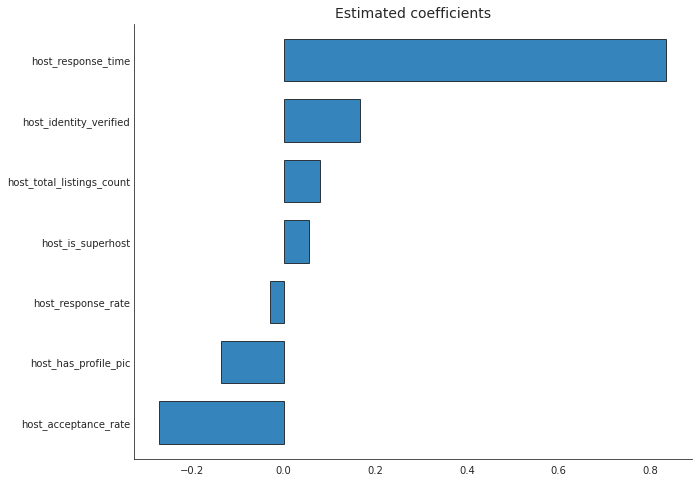

In [ ]:
coefplot(lasso, list(train_features_lasso.columns))
plt.show()

Two insights:


*   the host response time has a significant impact on the price of the listing compare to other predictors
*   host response rate and whether host has a profile pic don't affect the price



### "Superhost" Title

In [ ]:
# in this section we make "superhost" the response instead and build a logistic regression or classification model to determine feature importance
# we assume that the title of "superhost" will increase patronage on Airbnb website and hence rental income
# it was also identified previously that host_is_superhost has a positive correlation with rental price of an airbnb listing in sydney

In [ ]:
# splitting the training and testing data into features and response

train_features_superhost = df_train.copy().drop(['host_is_superhost'], axis=1)
test_features_superhost = df_test.copy().drop(['host_is_superhost'], axis=1)

train_response_superhost = df_train["host_is_superhost"]
test_response_superhost = df_test["host_is_superhost"]

In [ ]:
# Use CatBoost encoder to encode the remaining categorical variables

cat_predictor = ['neighbourhood_cleansed_aggregate', 'room_type', 'property_type_aggregate', 'host_response_time']

encoder = CatBoostEncoder().fit(train_features_superhost[cat_predictor], train_response) # we must use the training set for this
train_features_superhost[cat_predictor] = encoder.transform(train_features_superhost[cat_predictor])
test_features_superhost[cat_predictor] = encoder.transform(test_features_superhost[cat_predictor])

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV

model = LogisticRegression(class_weight = "balanced",max_iter = 400)

skf = StratifiedKFold(n_splits=7, shuffle = True, random_state=1)

In [ ]:
# Set up objective function for Bayes optimisation
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 2000)
    num_leaves = trial.suggest_int('num_leaves', 10, 40)
    min_child_samples = trial.suggest_int('min_child_samples', 10, 50)
    reg_alpha = trial.suggest_loguniform('reg_alpha',10**(-8),1)
    reg_lambda = trial.suggest_loguniform('reg_lambda',10**(-8),1)
    subsample = trial.suggest_uniform('subsample',0.4,1)
    colsample_bytree = trial.suggest_uniform('colsample_bytree',0.4,1)
    positive = trial.suggest_uniform('positive',1,10)

    model = lgb.LGBMClassifier(objective='binary',class_weight={0:1,1:positive}, boosting_type = 'gbdt',
                         n_estimators = n_estimators, learning_rate = 0.02,
                         num_leaves = num_leaves, min_child_samples=min_child_samples,
                         reg_alpha = reg_alpha, reg_lambda = reg_lambda,
                         subsample =subsample, subsample_freq  = 1,
                         colsample_bytree=colsample_bytree)
    # Cross-validation
    scores = cross_val_score(model, train_features_superhost, train_response_superhost, cv = 5, scoring = 'f1')
    gain = np.mean(scores)

    return gain # returns CV error for the best trial

sampler = TPESampler(seed = 42)
#Conducting bayes optimisation
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=10, timeout = 12000)  #in the interest of time, only 10 trials are ran

[I 2022-05-26 20:26:36,558] A new study created in memory with name: no-name-2b3c38ed-0f15-4c16-9bab-78e215d8905a
[I 2022-05-26 20:26:55,646] Trial 0 finished with value: 0.7111297827913724 and parameters: {'n_estimators': 780, 'num_leaves': 39, 'min_child_samples': 40, 'reg_alpha': 0.0006155564318973012, 'reg_lambda': 1.77071686435378e-07, 'subsample': 0.49359671220172163, 'colsample_bytree': 0.4348501673009197, 'positive': 8.795585311974417}. Best is trial 0 with value: 0.7111297827913724.
[I 2022-05-26 20:27:20,058] Trial 1 finished with value: 0.7392060061220855 and parameters: {'n_estimators': 1222, 'num_leaves': 31, 'min_child_samples': 10, 'reg_alpha': 0.574485163632042, 'reg_lambda': 0.04566054873446119, 'subsample': 0.5274034664069657, 'colsample_bytree': 0.5090949803242604, 'positive': 2.650640588680904}. Best is trial 1 with value: 0.7392060061220855.
[I 2022-05-26 20:27:34,410] Trial 2 finished with value: 0.7200211995856687 and parameters: {'n_estimators': 643, 'num_leaves

In [ ]:
study.best_params

{'colsample_bytree': 0.5090949803242604,
 'min_child_samples': 10,
 'n_estimators': 1222,
 'num_leaves': 31,
 'positive': 2.650640588680904,
 'reg_alpha': 0.574485163632042,
 'reg_lambda': 0.04566054873446119,
 'subsample': 0.5274034664069657}

In [ ]:
#Fit LightBGM with the best parameters from Bayes optimisation results
lgbm = lgb.LGBMClassifier(objective='binary',class_weight={0:1,1:2.793086078426724}, boosting_type = 'gbdt',
                         n_estimators = 619, learning_rate = 0.02,
                         num_leaves = 30, min_child_samples=16,
                         reg_alpha = 0.6278674353434425, reg_lambda = 0.04300111241809991,
                         subsample =0.6711518304797958, subsample_freq  = 1,
                         colsample_bytree=0.672762825442782)
lgbm.fit(train_features_superhost, train_response_superhost)
y_prob = lgbm.predict_proba(test_features_superhost)[:,1]
y_pred = lgbm.predict(test_features_superhost)

f1_score(test_response_superhost, y_pred)

0.6990595611285266

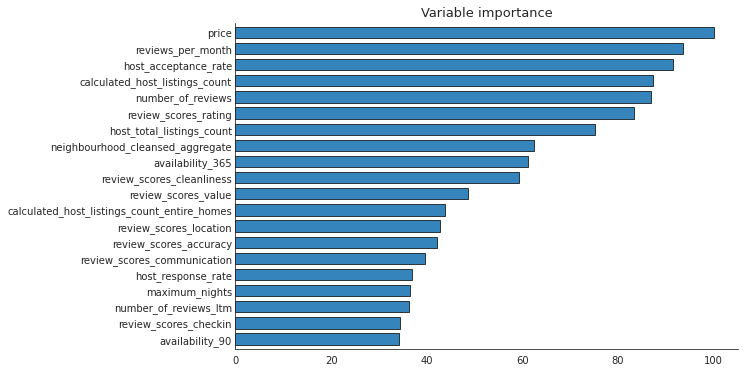

In [ ]:
#Feature importance plot
plot_feature_importance(lgbm, train_features_superhost.columns)
plt.show()